# Machine Learning Engineer Nanodegree
## Investment and Trading Capstone Project
## Project: Build a Stock Price Indicator
----
## Exploring the Data
Load necessary Python libraries and the price data. Note that the column from this dataset will be calculated to our target label (whether the next daily price" ups, flats or downs) and the features of other days. All other columns are features for near days. This project import the python module [`googlefinance.client`](https://pypi.python.org/pypi/googlefinance.client) instead of [`yahoo-finance`](http://pypi.python.org/pypi/yahoo-finance) [which is being discontinued](https://yahoo.sdx.socialdynamx.com/portal/conversation/19248672) although it is planned in the proposal. Because the trading days one year is a little few for machine learning, we will try to use ten years. This Notebook is inherited from the [Udacity project template: Finding Donors for CharityML](https://github.com/udacity/machine-learning/blob/master/projects/finding_donors/finding_donors.ipynb) and [Creating Customer Segments](https://github.com/udacity/machine-learning/blob/master/projects/customer_segments/customer_segments.ipynb).

In [1]:
import numpy                as     np
import pandas               as     pd
import seaborn              as     sns
import matplotlib.pyplot    as     plt
import matplotlib.dates     as     dates
from   datetime             import date, timedelta
from   time                 import time
from   IPython.display      import display                         # Allows the use of display() for DataFrames
from   collections          import OrderedDict

# Pretty display for notebooks
%matplotlib inline

In [39]:
random_state =  7
data_p       = '7Y'                # Years, data_period to get data from current date
Page_size    = 17                  # inch, for figure size
date_split   = date(2018,   1,  1) # Split train/test data by the date
day          = timedelta          (days    = 1)
concat       = lambda d: pd.concat(d, axis = 1)
ClassName    = lambda c: c.__class__.__name__
percent      = '{:6.2f}%'
R            = '#dd4b39'           # Google Red
G            = '#3cba54'           # Google Green
B            = '#4885ed'           # Google Blue
Y            = '#f4c20d'           # Google Yellow

In [3]:
from   googlefinance.client import get_price_data, get_prices_data #, get_prices_time_data
# Load daily prices of the S&P 500

data = get_price_data({
   'x': 'INDEXSP', # Stock exchange/traded symbol (S&P 500: 'INDEXSP', Dow Jones: 'INDEXDJX', NYSE COMPOSITE: 'INDEXNYSEGIS'  )
   'q': '.INX'   , # Stock symbol                 (S&P 500: '.INX'   , Dow Jones: '.DJI'    , NYSE COMPOSITE: 'NYA', 'AAPL'...)
   'i': '86400'  , # Interval seconds             ('86400' = 1 day  intervals)
   'p': data_p     # Period                       (   '1Y' = 1 year period   )
})                 # get price data               (return pandas dataframe)
# Success - Display the first record
display(data.tail(n = 1))

# Comparing to get_price_data, get_prices_data focuses on daily data (avoid confusion although the same data) and flexibility
data = get_prices_data([{
   'x': 'INDEXSP', # Stock exchange/traded symbol (S&P 500: 'INDEXSP', Dow Jones: 'INDEXDJX', NYSE COMPOSITE: 'INDEXNYSEGIS'  )
   'q': '.INX'   , # Stock symbol                 (S&P 500: '.INX'   , Dow Jones: '.DJI'    , NYSE COMPOSITE: 'NYA', 'AAPL'...)
}],     data_p   ) # get price data               (return pandas dataframe)
# Success - Display the first record
display(data.tail(n = 1))

# data     .  to_csv  ('SP.csv.txt')                                    # Save the got data (10 years: 125 KB)
# data = pd.read_csv  ('SP.csv.txt', index_col = 0, parse_dates = True) # Load the got data (when googlefinance fails)

,Open,High,Low,Close,Volume
2018-03-30 04:00:00,2614.41,2659.07,2609.72,2640.87,2348028811


,.INX_Open,.INX_High,.INX_Low,.INX_Close,.INX_Volume
2018-03-30,2614.41,2659.07,2609.72,2640.87,2348028811


### Implementation: Data Cleaning
The data with abnormal 0 needs to be cleaned

In [4]:
data  = data.rename(columns = lambda c: c.split('_')[-1]) # Clean column names
display(data.describe())                                  # Check data

,Open,High,Low,Close,Volume
count,1758.000000,1758.00000,1758.000000,1758.000000,1.758000e+03
mean,1880.828248,1889.47806,1871.607548,1882.677139,8.547434e+08
std,421.384029,421.45356,421.156759,419.107238,6.546684e+08
min,0.000000,0.00000,0.000000,1099.230000,0.000000e+00
25%,1461.027500,1465.51000,1456.955000,1461.242500,4.932898e+08
50%,1949.120000,1961.43000,1937.535000,1950.805000,5.835948e+08
75%,2121.877500,2128.37500,2112.777500,2124.020000,8.507497e+08
max,2867.230000,2872.87000,2851.480000,2872.870000,4.024144e+09


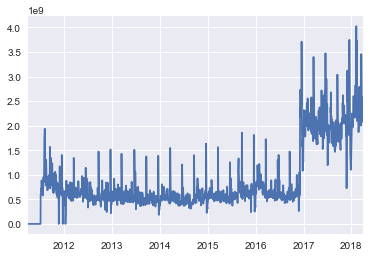

In [5]:
data['Volume'].plot();                                    # Check 0 Volumes

In [6]:
# Discard days with 0 Volumn & check again
Day_Volume  = data[data['Volume'] == 0].index[-1] + day
print 'Cleaned data with Volume start from: ' + str(Day_Volume)
data_Volume = data[Day_Volume:]
display(data_Volume.describe())

Cleaned data with Volume start from: 2012-01-15


,Open,High,Low,Close,Volume
count,1560.000000,1560.000000,1560.000000,1560.000000,1.560000e+03
mean,1959.953410,1968.404808,1950.988474,1962.068955,8.950498e+08
std,379.386872,379.940467,378.549014,376.045263,6.653034e+08
min,0.000000,0.000000,0.000000,1278.040000,1.839316e+08
25%,1666.077500,1676.750000,1658.295000,1671.072500,4.980469e+08
50%,2000.965000,2014.140000,1990.870000,2001.555000,5.778510e+08
75%,2162.207500,2168.230000,2151.965000,2163.360000,8.519090e+08
max,2867.230000,2872.870000,2851.480000,2872.870000,4.024144e+09


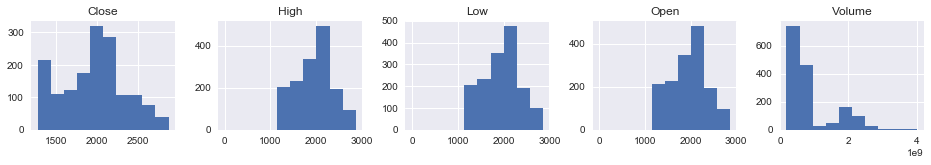

In [7]:
data_Volume.hist(figsize = (16, 2), layout = (1, 5));     # Check distribution

In [8]:
for c in ['Open', 'High', 'Low']:
    display(data_Volume[data_Volume[ c    ] < 1000]) # Check prices < 1000 (the strange gap in 'Open', 'High', and 'Low')

,Open,High,Low,Close,Volume
2017-08-01,0.0,0.0,0.0,2470.3,2189633778


,Open,High,Low,Close,Volume
2017-08-01,0.0,0.0,0.0,2470.3,2189633778


,Open,High,Low,Close,Volume
2017-08-01,0.0,0.0,0.0,2470.3,2189633778


,Open,High,Low,Close,Volume
count,1559.000000,1559.000000,1559.000000,1559.000000,1.559000e+03
mean,1961.210597,1969.667415,1952.239910,1961.742957,8.942194e+08
std,376.244061,376.774335,375.428637,375.945353,6.647077e+08
min,1277.820000,1282.550000,1266.740000,1278.040000,1.839316e+08
25%,1667.795000,1678.200000,1659.735000,1670.435000,4.980300e+08
50%,2001.200000,2015.940000,1991.010000,2001.540000,5.778148e+08
75%,2162.375000,2168.270000,2152.140000,2163.190000,8.506121e+08
max,2867.230000,2872.870000,2851.480000,2872.870000,4.024144e+09


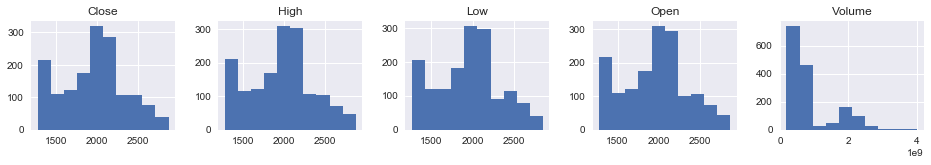

In [9]:
data_Volume_Price     = data_Volume[
                        data_Volume['Open'] > 1000] # Discard the abnormal day
data_Volume_Price     . hist(figsize = (16, 2), layout = (1, 5));
display               ( data_Volume_Price.describe())
data_clean            = data_Volume_Price

### Implementation: Data Exploration
A cursory investigation of the dataset will determine how many days fit into either group, and will tell us about the percentage of these daily prices uping or falling. In the code cell below, we will compute the basic following and additional statistics with [stockstats](https://pypi.python.org/pypi/stockstats):
- The total number of records, `'n_records'`.
- The number of the next daily prices upping, `'n_up'`.
- The number of the next daily prices downing, `'n_down'`.
- The number of the next daily prices flatting, `'n_flat'`.
- The percentage of the next daily prices upping, `'up_percent'`.

In [10]:
col_next    = ['Open'     , 'Close'     ]  # Combine next daily data and discard the last one which lacks the next daily data
d           = concat([data_clean, data_clean[col_next].shift(-1).rename(columns = lambda c: c + '_next')])[:-1]
y_rgr_col   = list(d         .columns[ -len (col_next):])

X_col       = list(data_clean.columns) + ['Open_Close']

for             p1        ,  p2 in      [
              ('Open'     , 'Close'     ), # Vector from Open      to Close
              ('Open'     ,  'Open_next'), # Vector from Open      to  Open_next
              ('Close'    ,  'Open_next'), # Vector from Close     to  Open_next
              ('Close'    , 'Close_next'), # Vector from Close     to Close_next
              ('Open_next', 'Close_next'), # Vector from Open_next to Close_next
              ]:
    d['_'.join([p1        ,  p2         ])] =          - d[p1]     +  d[p2]

y_clf_vec   = ['Close_Close_next', 'Open_Open_next', 'Close_Open_next', 'Open_next_Close_next']
Xy_col      = [c for c in d.columns if 0 <= c.find('Open_next') and c.find('Close_next') < 0]
y_clf_col   = []
for   vec     in y_clf_vec:                # Index of records where the next daily prices up
    col     =          vec + '_up'         # Merge 'flat' to 'up': Align to the 'up' of matplotlib.finance
    d[col]  =  0 <=  d[vec]
    y_clf_col.append  (col)

Close_Close_next_flat     =         0   == d.    Close_Close_next
Close_Open_next_flat      =         0   == d.     Close_Open_next

n_records                 = d.shape[0]                                # Total number of records
n_up                      = sum    (       d.Close_Close_next_up    )
n_flat                    = sum    (         Close_Close_next_flat  )
n_down                    = sum    (0    > d.Close_Close_next       )
up_percent                = float  (n_up)/n_records*100               # Percentage of days whose price up

print '[Example Daily Close-to-Close (Close_Close_next) prices]'
print 'Total number of records: {}'               .format(n_records )
print 'Daily prices upping:     {}  ({})'         .format(n_up      , 'Close_Close_next_up, including flatting to align the "up" of matplotlib.finance')
print 'Daily prices flatting:   {}'               .format(n_flat    )
print 'Daily prices downing:    {}'               .format(n_down    )
print 'Percentage of daily prices upping: {:.2f}%'.format(up_percent)

print '\nThe flat days with the same         Close     prices'
display       ( d[Close_Close_next_flat | Close_Close_next_flat.shift(1)])
print '\nThe flat day  with the same Open  & Close     prices'
display       ( d[    d.Open           ==     d.Close                   ])
print '\n     {} days with the same Close & Open_next prices'.format(sum(Close_Open_next_flat))
display       ( d[ Close_Open_next_flat |  Close_Open_next_flat.shift(1)].head(n = 2))

[Example Daily Close-to-Close (Close_Close_next) prices]
Total number of records: 1558
Daily prices upping:     842  (Close_Close_next_up, including flatting to align the "up" of matplotlib.finance)
Daily prices flatting:   1
Daily prices downing:    716
Percentage of daily prices upping: 54.04%

The flat days with the same         Close     prices


,Open,High,Low,Close,Volume,Open_next,Close_next,Open_Close,Open_Open_next,Close_Open_next,Close_Close_next,Open_next_Close_next,Close_Close_next_up,Open_Open_next_up,Close_Open_next_up,Open_next_Close_next_up
2017-01-10,2273.59,2275.49,2268.90,2268.9,1914652521,2269.72,2268.90,-4.69,-3.87,0.82,0.00,-0.82,True,False,True,False
2017-01-11,2269.72,2279.27,2265.27,2268.9,2138024556,2268.60,2275.32,-0.82,-1.12,-0.30,6.42,6.72,True,False,False,True



The flat day  with the same Open  & Close     prices


,Open,High,Low,Close,Volume,Open_next,Close_next,Open_Close,Open_Open_next,Close_Open_next,Close_Close_next,Open_next_Close_next,Close_Close_next_up,Open_Open_next_up,Close_Open_next_up,Open_next_Close_next_up
2017-04-11,2357.16,2366.37,2351.5,2357.16,1620328913,2353.92,2353.78,0.0,-3.24,-3.24,-3.38,-0.14,False,False,False,False



     130 days with the same Close & Open_next prices


,Open,High,Low,Close,Volume,Open_next,Close_next,Open_Close,Open_Open_next,Close_Open_next,Close_Close_next,Open_next_Close_next,Close_Close_next_up,Open_Open_next_up,Close_Open_next_up,Open_next_Close_next_up
2012-02-07,1344.32,1344.36,1337.52,1344.33,531777345,1344.33,1347.05,0.01,0.01,0.00,2.72,2.72,True,True,True,True
2012-02-08,1344.33,1349.24,1335.92,1347.05,535133187,1347.04,1349.96,2.72,2.71,-0.01,2.91,2.92,True,True,False,True


** Featureset Exploration **

All features are continuous

In [11]:
hdr_reg  =  'Regular Features'                             # Headers
hdr_opt  = 'Optional Features (when y excludes Open_next)' #
def XXy_display      ( d,     X_col           ,      Xy_col       ):
    XXy  =  pd.concat([d[     X_col          ], d[   Xy_col      ]], keys =
                      [     hdr_reg           ,     hdr_opt       ], axis = 1)
    display(XXy.tail())
    return  XXy
def y_display        ( d, y_clf_col           ,   y_rgr_col       ):
    y    =  pd.concat([d[ y_clf_col          ], d[y_rgr_col      ]], keys =
                      [  'y (Classifications)',  'y (Regressions)'], axis = 1)
    display(  y.tail())
    return    y

XXy_display(           d,     X_col           ,      Xy_col       )
y_display  (           d, y_clf_col           ,   y_rgr_col       )
display    (           d[ y_clf_vec          ].rename(columns = lambda c: ('Vectors for Classification', c)).tail())

Regular Features                                                    \
                       Open     High      Low    Close      Volume Open_Close   
2018-03-23          2691.36  2695.68  2641.59  2643.69  2492921032     -47.67   
2018-03-24          2646.71  2657.67  2585.89  2588.26  2558217934     -58.45   
2018-03-27          2619.35  2661.36  2601.81  2658.55  2434497989      39.20   
2018-03-28          2667.57  2674.78  2596.12  2612.62  2501316081     -54.95   
2018-03-29          2611.30  2632.65  2593.06  2605.00  2574191549      -6.30   

           Optional Features (when y excludes Open_next)                 \
                                               Open_next Open_Open_next   
2018-03-23                                       2646.71         -44.65   
2018-03-24                                       2619.35         -27.36   
2018-03-27                                       2667.57          48.22   
2018-03-28                                       2611.30         -56.27   
2018-03-29                                       2614.41           3.11   

                            
           Close_Open_next  
2018-03-23            3.02  
2018-03-24           31.09  
2018-03-27            9.02  
2018-03-28           -1.32  
2018-03-29            9.41

y (Classifications)                                       \
           Close_Close_next_up Open_Open_next_up Close_Open_next_up   
2018-03-23               False             False               True   
2018-03-24                True             False               True   
2018-03-27               False              True               True   
2018-03-28               False             False              False   
2018-03-29                True              True               True   

                                   y (Regressions)             
           Open_next_Close_next_up       Open_next Close_next  
2018-03-23                   False         2646.71    2588.26  
2018-03-24                    True         2619.35    2658.55  
2018-03-27                   False         2667.57    2612.62  
2018-03-28                   False         2611.30    2605.00  
2018-03-29                    True         2614.41    2640.87

Vectors for Classification                                 \
                     Close_Close_next Open_Open_next Close_Open_next   
2018-03-23                     -55.43         -44.65            3.02   
2018-03-24                      70.29         -27.36           31.09   
2018-03-27                     -45.93          48.22            9.02   
2018-03-28                      -7.62         -56.27           -1.32   
2018-03-29                      35.87           3.11            9.41   

                                 
           Open_next_Close_next  
2018-03-23               -58.45  
2018-03-24                39.20  
2018-03-27               -54.95  
2018-03-28                -6.30  
2018-03-29                26.46

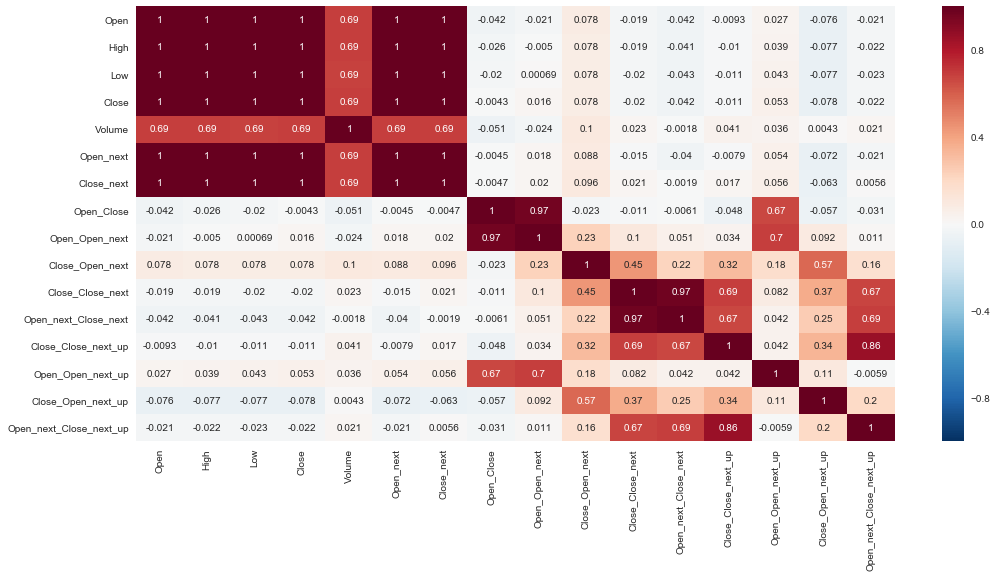

In [12]:
def corr_heatmap(data):
    corr =       data.corr()
    _, _ = plt.subplots(figsize   = (Page_size, Page_size/2))
    sns.heatmap (     corr, annot = True);
corr_heatmap(d)

In [13]:
from stockstats import StockDataFrame
# from copy       import deepcopy
# s_copy  =              deepcopy(d     )
# s       = StockDataFrame.retype(s_copy)          # The data => StockDataFrame
s       = StockDataFrame.retype(d.copy())          # The data => StockDataFrame
stats   = ['volume_delta', 'open_-2_r', 'cr', 'cr-ma1', 'cr-ma2', 'cr-ma3', 'volume_-3,2,-1_max', 'volume_-3~1_min',
           'kdjk', 'kdjd', 'kdjj', 'open_2_sma', 'macd', 'macds', 'macdh', 'boll', 'boll_ub', 'boll_lb', 'cr-ma2_xu_cr-ma1_20_c',
           'rsi_6', 'rsi_12', 'wr_10', 'wr_6', 'cci', 'cci_20', 'tr', 'atr', 'dma', 'pdi', 'mdi', 'dx', 'adx', 'adxr',
           'trix', 'trix_9_sma', 'vr', 'vr_6_sma'] # Examples from the Tutorial of the stockstats

In [14]:
# [ s[stat] for stat in  stats]                    # Generate relative statistics
for             stat in  stats:                    # Generate relative statistics
    s[stat]                                        # The SettingWithCopyWarning might in stockstats.StockDataFrame

C:\ProgramData\Anaconda2\lib\site-packages\pandas\core\indexing.py:179: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self._setitem_with_indexer(indexer, value)


In [15]:
def display_n     (data, right = '',  corr = False,
                                      n    = 5):
    with pd.option_context('display.max_rows', None, 'display.max_columns', None):
        display  ((data.loc[:, right:] if right else data).describe())
        if  corr:
            print '\nTop {} Positive/Negative Correlation with {} of Statistics'  . format(n     ,  corr )
            corr = data    .corr   ()[corr]                  .sort_values(by      =                 corr , ascending = False)
            display(concat([corr.head(n   = n)      .reset_index().rename(columns = {'index': 'Positive'}),
                            corr.tail(n   = n)[::-1].reset_index().rename(columns = {'index': 'Negitive'})])
                                                                  .rename(index   = lambda i: i + 1))

print 'Some raw and side statistics examples of the stockstats might incomplete in the first few days:'
display_n  ( s, stats[0])                          # display only new features

print '\nThe statistics with the most day number of data:'
stats_days = pd.DataFrame([(c, ([int(c) for c in c.split('_') if c.isdigit()] or [0])[0]) for c in s.columns],
                                                                          columns = ['Statistics', 'Days']
                                                            ).sort_values(by      =                'Days', ascending = False
                                                            ).reset_index(drop    = 1
                                                            )     .rename(index   = lambda i: i + 1)
display                 (stats_days.head())
stats_day  =         max(stats_days.Days  )
s_cplt     = s     .iloc[stats_day:-  stats_day                      ]
s_cplt     = s_cplt. loc[         :, (s_cplt  != s_cplt.iloc[0]).any()]
print 'Dropped the first, last {} days and constant statistics are dropped to complete integrity'.format(stats_day)

Some raw and side statistics examples of the stockstats might incomplete in the first few days:


,volume_delta,open_-2_r,middle,cr,cr-ma1,cr-ma2,cr-ma3,volume_-3_s,volume_-1_s,volume_2_s,"volume_-3,2,-1_max",volume_-2_s,volume_0_s,volume_1_s,volume_-3~1_min,rsv_9,kdjk_9,kdjk,kdjd_9,kdjd,kdjj_9,kdjj,open_2_sma,close_26_ema,macd,macds,macdh,close_20_sma,close_20_mstd,boll,boll_ub,boll_lb,cr-ma1_20_c,close_-1_s,close_-1_d,rs_6,rsi_6,rs_12,rsi_12,wr_10,wr_6,middle_14_sma,cci,middle_20_sma,cci_20,tr,atr,close_10_sma,close_50_sma,dma,high_delta,um,low_delta,dm,pdm,pdm_14_ema,pdm_14,atr_14,pdi_14,pdi,mdm,mdm_14_ema,mdm_14,mdi_14,mdi,dx_14,dx,dx_6_ema,adx,adx_6_ema,adxr,trix,trix_9_sma,change,vr,vr_6_sma
count,1.557000e+03,1556.000000,1558.000000,1557.000000,1554.000000,1552.000000,1548.000000,1.555000e+03,1.557000e+03,1.556000e+03,1.558000e+03,1.556000e+03,1.558000e+03,1.557000e+03,1.558000e+03,1558.000000,1558.000000,1558.000000,1558.000000,1558.000000,1558.000000,1558.000000,1558.000000,1558.000000,1558.000000,1558.000000,1558.000000,1558.000000,1557.000000,1558.000000,1557.000000,1557.000000,1535.0,1557.000000,1557.000000,1557.000000,1557.000000,1557.000000,1557.000000,1558.000000,1558.000000,1558.000000,1557.000000,1558.000000,1557.000000,1557.000000,1557.000000,1558.000000,1558.000000,1558.000000,1557.000000,1557.000000,1557.000000,1557.000000,1558.000000,1558.000000,1558.000000,1557.000000,1557.000000,1557.000000,1558.000000,1558.000000,1558.000000,1557.000000,1557.000000,1557.000000,1557.000000,1557.000000,1557.000000,1557.000000,1557.000000,1557.000000,1557.000000,1557.000000,1557.000000,1553.000000
mean,1.240991e+06,0.097587,1960.783297,124.235233,124.639886,125.018234,125.706464,8.901801e+08,8.922067e+08,8.935875e+08,1.030685e+09,8.911725e+08,8.932863e+08,8.934477e+08,7.583026e+08,63.246630,63.289169,63.289169,63.324946,63.324946,63.217613,63.217613,1960.367375,1950.265811,6.245916,6.280494,-0.069155,1952.912308,22.888273,1952.912308,1999.112260,1907.559168,20.0,1960.893642,0.842216,inf,57.112795,inf,56.560699,36.348072,38.075691,1955.088151,27.656805,1952.352012,32.730896,18.389576,18.118266,1957.444554,1939.480361,17.964193,0.853982,4.623886,0.836763,4.655119,4.480777,4.472631,4.472631,18.118266,25.276379,25.276379,4.558222,4.495236,4.495236,23.096245,23.096245,31.737101,31.737101,31.810929,31.810929,31.901500,31.901500,0.047899,0.048407,0.048047,inf,125.815758
std,2.637004e+08,1.068485,375.734192,51.115513,49.194588,47.184265,42.874306,6.607513e+08,6.627428e+08,6.642722e+08,7.450595e+08,6.616980e+08,6.638989e+08,6.640816e+08,5.672439e+08,30.698893,23.289553,23.289553,20.242496,20.242496,36.475486,36.475486,375.940361,372.528177,13.086822,11.941852,9.431528,373.847962,13.095374,373.847962,380.222094,368.711730,0.0,375.437766,15.457977,NaN,17.534743,NaN,12.225157,30.572850,31.139637,374.662937,105.891659,373.917248,108.365288,12.067362,6.687713,375.037300,369.861655,37.253161,11.832050,7.094844,14.787449,9.881631,7.130787,2.159657,2.159657,6.687713,9.440943,9.440943,9.901001,3.815648,3.815648,11.750628,11.750628,21.258696,21.258696,15.568426,15.568426,13.699619,13.699619,0.107047,0.103085,0.784714,NaN,53.902003
min,-1.854808e+09,-6.911553,1275.823333,35.036925,44.631415,52.251135,55.682846,1.839316e+08,1.839316e+08,1.839316e+08,3.782322e+08,1.839316e+08,1.839316e+08,1.839316e+08,1.839316e+08,0.000000,4.666604,4.666604,9.879499,9.879499,-22.128273,-22.128273,1278.055000,1293.670000,-47.639949,-40.305676,-61.144555,1293.670000,5.550314,1293.670000,1321.177249,1270.300916,20.0,1278.040000,-113.190000,0.067665,6.337629,0.174513,14.858333,0.000000,0.000000,1295.630000,-340.578134,1295.630000,-395.599439,3.700000,9.318114,1293.670000,1293.670000,-125.243000,-72.360000,0.000000,-121.800000,0.000000,0.000000,0.000000,0.000000,9.318114,4.532342,4.532342,0.000000,0.000000,0.000000,0.000000,0.000000,0.010822,0.010822,6.959956,6.959956,10.029961,10.029961,-0.368495,-0.346507,-4.097924,34.691762,46.627682
25%,-6.627792e+07,-0.411426,1667.892500,89.060567,91.205184,91.916426,94.953620,4.979392e+08,4.979962e+08,4.979677e+08,5.640408


The statistics with the most day number of data:


,Statistics,Days
1,close_50_sma,50
2,close_26_ema,26
3,cr-ma2_xu_cr-ma1_20_c,20
4,cr-ma1_20_c,20
5,cci_20,20


Dropped the first, last 50 days and constant statistics are dropped to complete integrity


In [16]:
display_n(s_cplt, right = stats[0], corr = ['close_close_next_up', 'close_close_next'], n = 10)

,volume_delta,open_-2_r,middle,cr,cr-ma1,cr-ma2,cr-ma3,volume_-3_s,volume_-1_s,volume_2_s,"volume_-3,2,-1_max",volume_-2_s,volume_0_s,volume_1_s,volume_-3~1_min,rsv_9,kdjk_9,kdjk,kdjd_9,kdjd,kdjj_9,kdjj,open_2_sma,close_26_ema,macd,macds,macdh,close_20_sma,close_20_mstd,boll,boll_ub,boll_lb,close_-1_s,close_-1_d,rs_6,rsi_6,rs_12,rsi_12,wr_10,wr_6,middle_14_sma,cci,middle_20_sma,cci_20,tr,atr,close_10_sma,close_50_sma,dma,high_delta,um,low_delta,dm,pdm,pdm_14_ema,pdm_14,atr_14,pdi_14,pdi,mdm,mdm_14_ema,mdm_14,mdi_14,mdi,dx_14,dx,dx_6_ema,adx,adx_6_ema,adxr,trix,trix_9_sma,change,vr,vr_6_sma
count,1.458000e+03,1458.000000,1458.000000,1458.000000,1458.000000,1458.000000,1458.000000,1.458000e+03,1.458000e+03,1.458000e+03,1.458000e+03,1.458000e+03,1.458000e+03,1.458000e+03,1.458000e+03,1458.000000,1458.000000,1458.000000,1458.000000,1458.000000,1458.000000,1458.000000,1458.000000,1458.000000,1458.000000,1458.000000,1458.000000,1458.000000,1458.000000,1458.000000,1458.000000,1458.000000,1458.000000,1458.000000,1458.000000,1458.000000,1458.000000,1458.000000,1458.000000,1458.000000,1458.000000,1458.000000,1458.000000,1458.000000,1458.000000,1458.000000,1458.000000,1458.000000,1458.000000,1458.000000,1458.000000,1458.000000,1458.000000,1458.000000,1458.000000,1458.000000,1458.000000,1458.000000,1458.000000,1458.000000,1458.000000,1458.000000,1458.000000,1458.000000,1458.000000,1458.000000,1458.000000,1458.000000,1458.000000,1458.000000,1458.000000,1458.000000,1458.000000,1458.000000,1458.000000
mean,1.403383e+06,0.099088,1955.007757,121.830593,121.401870,121.195577,120.898159,8.454612e+08,8.475040e+08,8.512895e+08,9.813901e+08,8.464254e+08,8.489073e+08,8.501326e+08,7.183770e+08,63.054532,63.044568,63.044568,63.030542,63.030542,63.072621,63.072621,1954.492534,1944.244276,6.262309,6.213761,0.097096,1946.855700,22.081687,1946.855700,1991.019074,1902.692326,1954.636852,0.935460,1.811629,56.818895,1.455416,56.137278,36.577167,38.123980,1949.008573,26.560516,1946.289754,31.653087,17.740885,17.695154,1951.387136,1933.530115,17.857022,0.952257,4.513669,0.930514,4.373299,4.377291,4.348762,4.348762,17.695154,25.046576,25.046576,4.287346,4.288774,4.288774,23.080286,23.080286,30.992511,30.992511,30.942120,30.942120,30.908984,30.908984,0.045968,0.045957,0.049276,122.908357,122.892833
std,2.579193e+08,1.037150,342.826335,46.548513,43.321648,40.376857,35.014330,6.095039e+08,6.110567e+08,6.152369e+08,6.880451e+08,6.101797e+08,6.127298e+08,6.140818e+08,5.220967e+08,30.733589,23.320524,23.320524,20.306461,20.306461,36.474553,36.474553,342.575886,338.152884,12.767326,11.731512,8.747978,339.139340,11.410695,339.139340,340.292006,339.520200,342.545991,14.411228,1.469979,17.258618,0.709272,11.659494,30.624219,31.097830,340.089593,105.884969,339.112362,108.399103,10.371989,5.610045,340.866613,335.286121,36.549391,11.183952,6.875371,13.376989,8.593251,6.911021,1.981305,1.981305,5.610045,9.282895,9.282895,8.613729,3.085884,3.085884,11.101926,11.101926,20.566816,20.566816,14.513390,14.513390,12.253639,12.253639,0.106647,0.102832,0.763398,53.553837,51.162652
min,-1.854808e+09,-6.686069,1275.823333,35.036925,44.631415,52.251135,55.682846,1.839316e+08,1.839316e+08,1.839316e+08,3.782322e+08,1.839316e+08,1.839316e+08,1.839316e+08,1.839316e+08,0.000000,4.666604,4.666604,9.879499,9.879499,-22.128273,-22.128273,1278.055000,1324.032208,-47.639949,-40.305676,-47.470134,1310.821000,5.550314,1310.821000,1341.444192,1270.300916,1278.040000,-77.680000,0.067665,6.337629,0.174513,14.858333,0.000000,0.000000,1306.971190,-340.578134,1310.760500,-395.599439,3.700000,9.318114,1305.426000,1332.767800,-125.243000,-72.360000,0.000000,-103.880000,0.000000,0.000000,0.922933,0.922933,9.318114,4.532342,4.532342,0.000000,0.257627,0.257627,2.451626,2.451626,0.010822,0.010822,6.959956,6.959956,10.029961,10.029961,-0.368495,-0.346507,-3.941367,34.691762,46.627682
25%,-6.370834e+07,-0.404311,1689.490000,89.334823,91.134340,91.804888,94.260908,4.937234e+08,4.937234e+08,4.937234e+08,5.591259e+


Top 10 Positive/Negative Correlation with ['close_close_next_up', 'close_close_next'] of Statistics


,Positive,close_close_next_up,close_close_next,Negitive,close_close_next_up,close_close_next
1,close_close_next_up,1.000000,0.714812,rsi_12,-0.058075,-0.068937
2,open_next_close_next_up,0.861986,0.696491,rsi_6,-0.055004,-0.065704
3,close_close_next,0.714812,1.000000,rsv_9,-0.054145,-0.064638
4,open_next_close_next,0.693753,0.978024,open_close,-0.054007,-0.015725
5,close_open_next,0.367196,0.482248,rs_12,-0.053472,-0.048782
6,close_open_next_up,0.355915,0.406368,close_-1_d,-0.052928,-0.018059
7,volume,0.054095,0.054592,rs_6,-0.052555,-0.037513
8,volume_0_s,0.054095,0.054592,change,-0.048468,-0.015271
9,wr_10,0.053172,0.067104,cci_20,-0.048401,-0.059285
10,wr_6,0.053071,0.064888,cci,-0.046014,-0.057071


In [17]:
X_stat_col = []
for    col          ,   stat     in [
     ('RSI6'        ,  'rsi_6'      ),          # 6 days Relative Strength Index (RSI)
     ('C2M'         ,  'close_2_sma'),          # 2 days simple moving average (rolling means) on close price
     ('MACD'        ,  'macd'       ),          # Moving Average Convergence Divergence (MACD)
     ('Boll_u'      ,  'boll_ub'    ),          # Bollinger Upper Bands
     ('Boll'        ,  'boll'       ),          # Bollinger       Bands
     ('Boll_l'      ,  'boll_lb'    ),          # Bollinger Lower Bands
                                    ]:
    d[ col      ]   = s[stat        ]
    X_stat_col.append(col)
X_col += X_stat_col
display(   d.loc[  :,  'RSI6':].head(n = 6))
data_raw = d    [6 :         ]
print 'The first 5 days w/o sufficient data for 6-day RSI be dropped'
display(   d.loc[  :,  'RSI6':].tail(     ))

,RSI6,C2M,MACD,Boll_u,Boll,Boll_l
2012-01-18,NaN,1293.670,0.000000,NaN,1293.670000,NaN
2012-01-19,100.000000,1300.855,0.322404,1321.177249,1300.855000,1280.532751
2012-01-20,100.000000,1311.270,0.611131,1326.728083,1305.403333,1284.078584
2012-01-21,100.000000,1314.940,0.759244,1327.964816,1307.897500,1287.830184
2012-01-24,100.000000,1315.690,0.848414,1328.347320,1309.518000,1290.688680
2012-01-25,89.730858,1315.325,0.828343,1327.728243,1310.373333,1293.018423


The first 5 days w/o sufficient data for 6-day RSI be dropped


,RSI6,C2M,MACD,Boll_u,Boll,Boll_l
2018-03-23,17.991290,2677.810,-6.664241,2803.319140,2731.8980,2660.476860
2018-03-24,12.184685,2615.975,-16.639318,2819.488351,2723.9460,2628.403649
2018-03-27,41.107915,2623.405,-18.657749,2813.926644,2717.8935,2621.860356
2018-03-28,32.670391,2635.585,-23.690448,2817.265582,2711.3105,2605.355418
2018-03-29,31.387795,2608.810,-27.971332,2821.971635,2705.8690,2589.766365


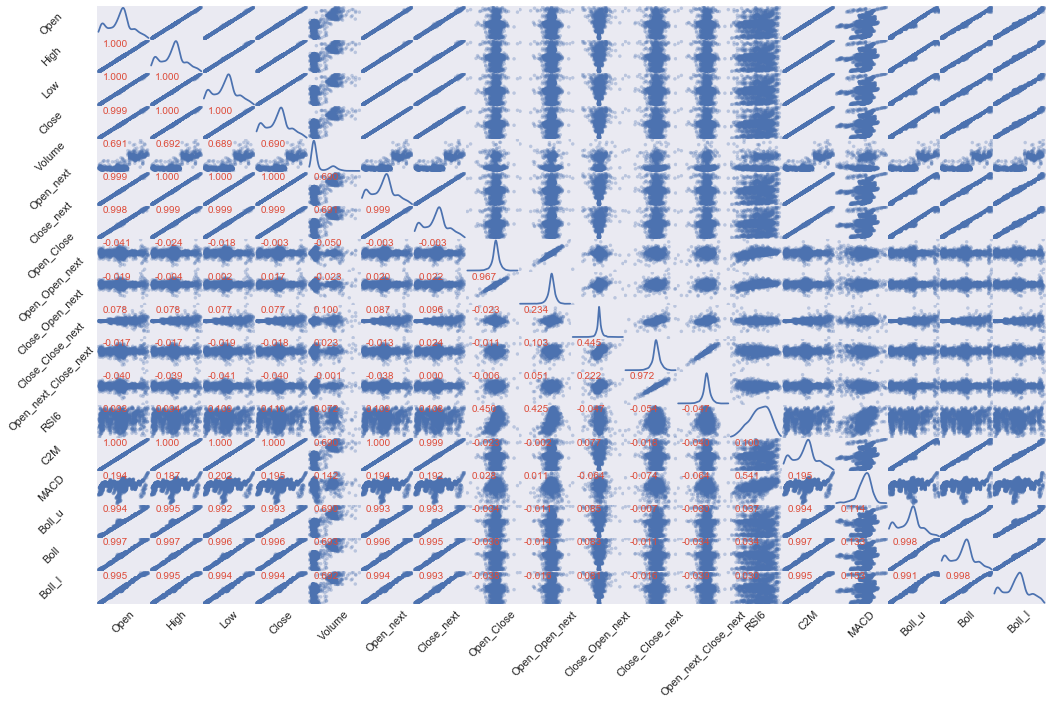

In [18]:
# print 'Produce a scatter matrix for each pair of features in the data'
data_corr = data_raw[[c for c in d.columns if c.find('up') < 0]]
mtrx_corr = data_corr.corr().as_matrix()
axs       = pd.plotting.scatter_matrix(data_corr, alpha = 0.3, figsize = (Page_size, Page_size*2/3), diagonal = 'kde')
for          i, j in  zip (*np.tril_indices_from(axs, k = 0)):
    ax = axs[i, j]
    if       i!=j:
        ax.annotate('%.3f' %mtrx_corr[i, j], ( 0.1, 0.8), xycoords = 'axes fraction', color = R)
    ax.get_yaxis().set_label_coords          (-0.8, 0.4)
    ax.xaxis.label.set_rotation(45)
    ax.yaxis.label.set_rotation(45)
    ax.set_xticks(())
    ax.set_yticks(())

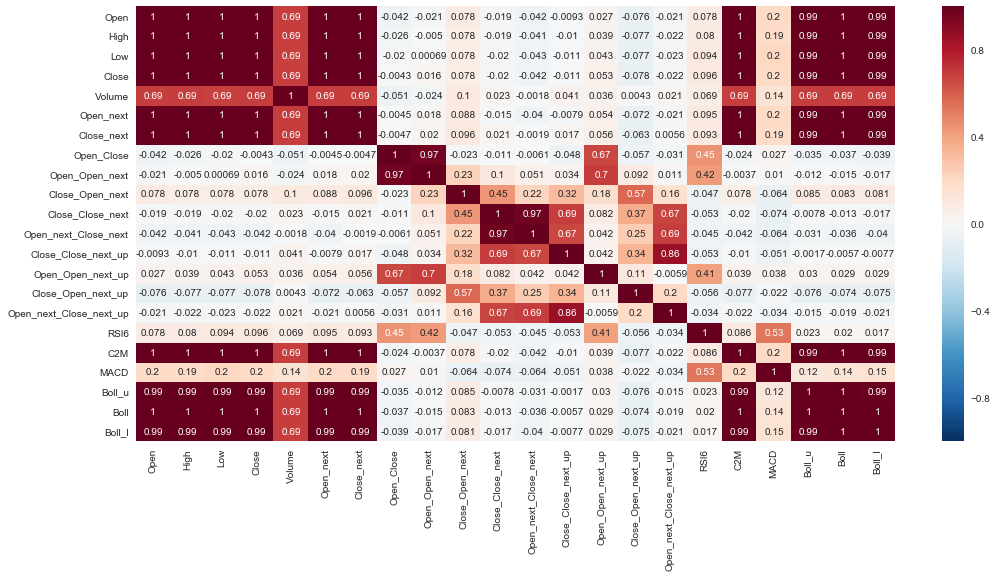

In [19]:
corr_heatmap(d)

Test Data


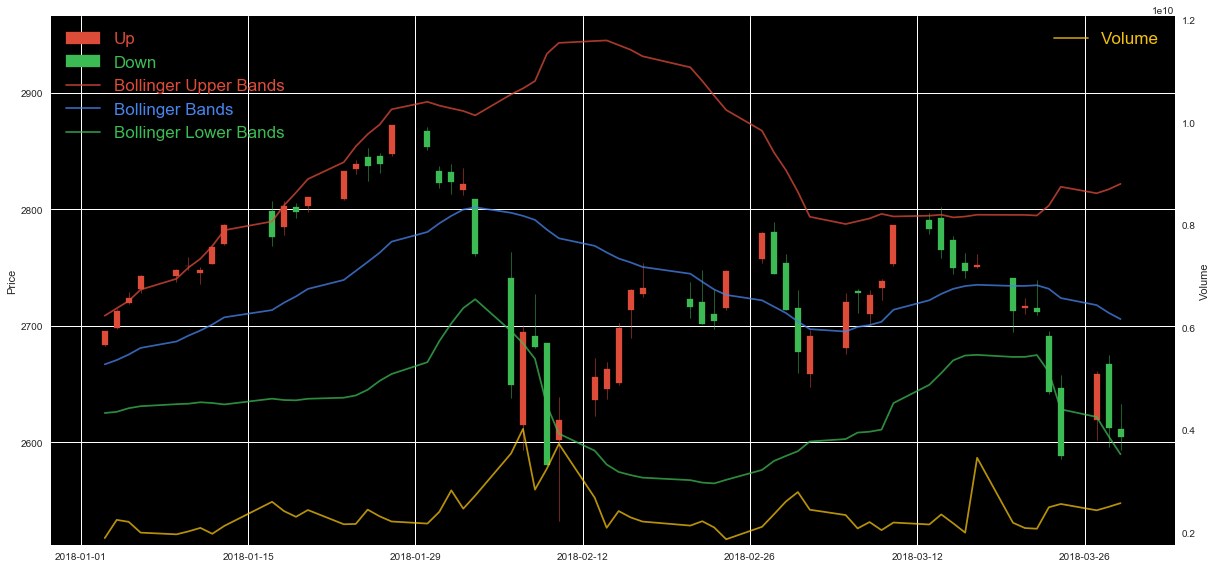

All Data


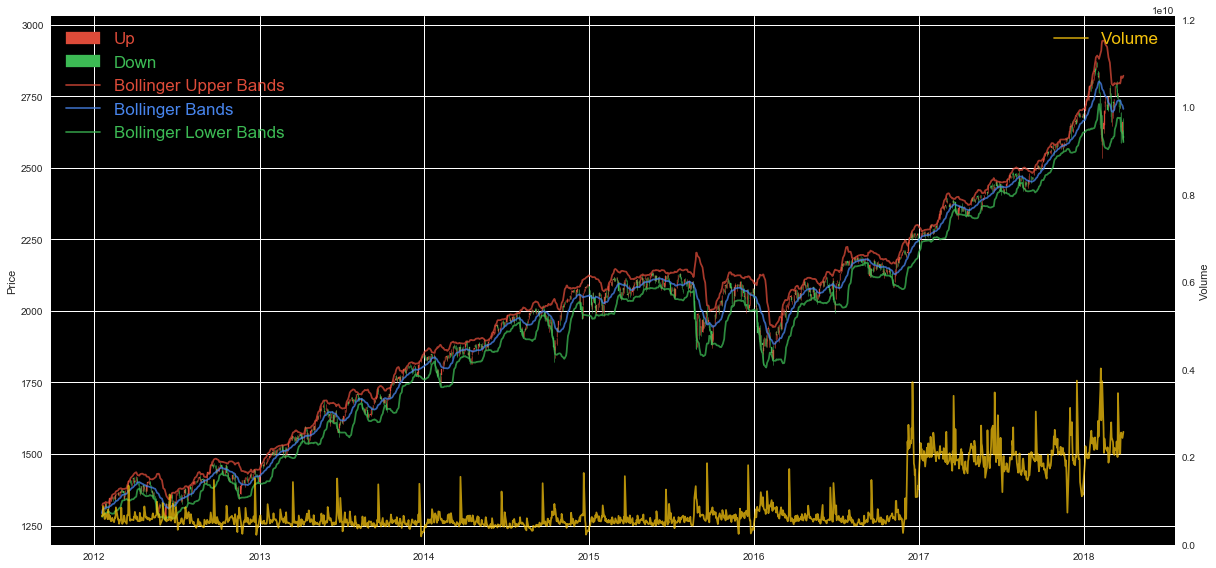

In [20]:
# Candle Stick Plot of open, high, low, close and Volume
from matplotlib.finance import candlestick_ohlc #, volume_overlay3
from matplotlib.patches import Patch

def FigStock(    x, size = 16, boll = False):
    x=           x. reset_index()
    x['index'] = x      ['index'].apply (dates.  date2num)
    fig, axP   = plt.subplots(figsize = (size , size/2  ))
    candlestick_ohlc(axP, x.values,    colorup = R ,   colordown = G, width = .5)
    axP. set_facecolor  ('#000000')
    axP.xaxis_date()
    axP. set_prop_cycle (  'color' ,      [      R ,  B    ,       G ])
    if  boll:
        boll = axP.plot (x['index'],    x[['Boll_u', 'Boll', 'Boll_l']].values, alpha = 0.75)
    axV      = axP.twinx()
    axV           .plot (x['index'],    x[ 'Volume'                   ].values, alpha = 0.75, label = 'Volume', color = Y)
    axV.grid      (False)
    axV.set_ylim  (None            ,  3*x[ 'Volume'].max())
    axV.set_ylabel(                        'Volume')
    axP.set_ylabel(                        'Price' )
    axV                   .legend( prop   = {'size': size}, loc = 'best'         ).get_texts()[0].set_color(Y)
    for text, c in zip(axP.legend([Patch(color = R), Patch(color = G)] +   boll,
                                  [            'Up',              'Down', 'Bollinger Upper Bands' ,
                                                                          'Bollinger Bands'       ,
                                                                          'Bollinger Lower Bands'],
                                   prop   = {'size': size}, loc = 'upper left'   ).get_texts()    ,
                                  [              R ,               G,      R, B, G]):
        text.set_color(c)
    plt.tight_layout()
    return axP, x

print 'Test Data'
FigStock(d[date_split:], Page_size, boll = True);
plt.show()
print  'All Data'
FigStock(d             , Page_size, boll = True);

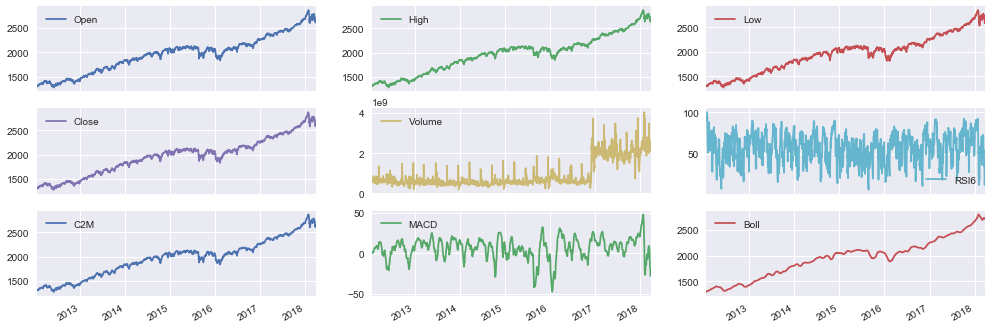

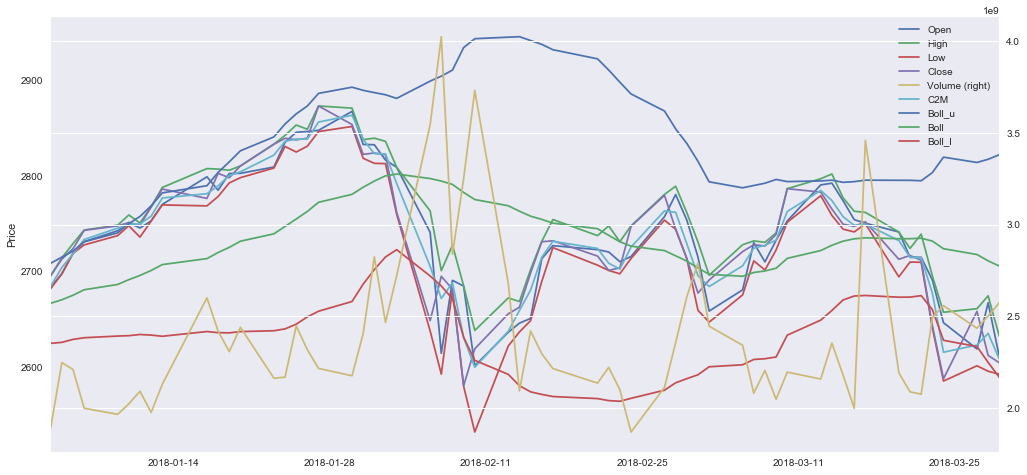

In [21]:
d_plot = d.drop([c for c in d.columns if 1 < len(c.split('_'   ))]                                 , axis = 1)
d_plot                       .plot(figsize  =   (Page_size, Page_size/2), subplots    = True, layout = (4, 3));
d_plot = d.drop([c for c in d.columns if 0 <=    c.find ('next') ] + ['Open_Close', 'RSI6', 'MACD'], axis = 1)
ax     = d_plot [date_split:].plot(figsize  =   (Page_size, Page_size/2), secondary_y = 'Volume');
ax     . set_ylabel('Price');

----
## Preparing the Data
### Normalizing Numerical Features
We will use [`sklearn.preprocessing.MinMaxScaler`](http://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.MinMaxScaler.html) first and try others later.

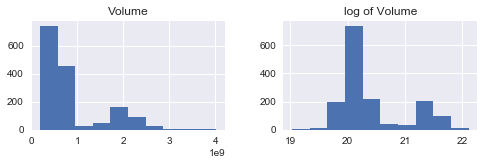

In [22]:
# Try Log-transform for the special feature
log           = ['Volume']
data_log      = data_raw     .copy  ()
data_log[log] = data_log[log].apply (          lambda x: np.log(x  + 1))
concat( [       data_raw[log],
                data_log[log].rename(columns = lambda c: 'log of ' + c)]).hist(figsize = (8, 2));

In [23]:
from sklearn.preprocessing import MinMaxScaler, StandardScaler, RobustScaler
numerical = [c for c in data_raw.columns if c.find('up') < 0]
for data_scale, name in ((data_raw, 'data_raw'), (data_log, 'data_log'),):
# for data_scale, name in ((data_log, 'data_log'), (data_raw, 'data_raw'),):
    for scaler in (  RobustScaler(), StandardScaler(), MinMaxScaler(),):
#     for scaler in (StandardScaler(),   MinMaxScaler(), RobustScaler(),):
        data_scaled                  =                           data_scale .copy()
        data_scaled[numerical]       =      scaler.fit_transform(data_scaled[numerical])
        print '\n[{} with {}]'.format(name, ClassName(scaler))
#         display(data_scaled.head(n = 5)) # Show examples of records with scaling applied
        display(data_scaled.tail(n = 5))
        display(data_scaled.describe())


[data_raw with RobustScaler]


,Open,High,Low,Close,Volume,Open_next,Close_next,Open_Close,Open_Open_next,Close_Open_next,...,Close_Close_next_up,Open_Open_next_up,Close_Open_next_up,Open_next_Close_next_up,RSI6,C2M,MACD,Boll_u,Boll,Boll_l
2018-03-23,1.418660,1.402702,1.350997,1.322337,5.440809,1.327029,1.211139,-3.619207,-3.280499,1.223242,...,False,False,True,False,-1.586414,1.396787,-0.953927,1.513160,1.503047,1.432637
2018-03-24,1.326672,1.324186,1.235205,1.208119,5.626224,1.270597,1.356404,-4.421738,-2.048798,12.668705,...,True,False,True,True,-1.814191,1.268720,-1.609854,1.546746,1.486817,1.368548
2018-03-27,1.270305,1.331808,1.268300,1.352957,5.274913,1.370054,1.261483,2.847943,3.335352,3.669725,...,False,True,True,False,-0.679613,1.284108,-1.742580,1.535194,1.474464,1.355473
2018-03-28,1.369648,1.359529,1.256472,1.258314,5.464647,1.253994,1.245735,-4.161176,-4.108281,-0.546381,...,False,False,False,False,-1.010594,1.309334,-2.073513,1.542129,1.461029,1.322493
2018-03-29,1.253720,1.272503,1.250110,1.242613,5.671582,1.260408,1.319866,-0.539363,0.121817,3.828746,...,True,True,True,True,-1.060906,1.253880,-2.355010,1.551905,1.449923,1.291343


,Open,High,Low,Close,Volume,Open_next,Close_next,Open_Close,Open_Open_next,Close_Open_next,Close_Close_next,Open_next_Close_next,RSI6,C2M,MACD,Boll_u,Boll,Boll_l
count,1552.000000,1552.000000,1552.000000,1552.000000,1552.000000,1552.000000,1552.000000,1552.000000,1552.000000,1552.000000,1552.000000,1552.000000,1.552000e+03,1.552000e+03,1552.000000,1.552000e+03,1.552000e+03,1552.000000
mean,-0.081251,-0.092675,-0.077710,-0.078583,0.900976,-0.080771,-0.077601,-0.032988,-0.040062,0.128745,-0.001571,-0.032278,-5.694618e-02,-8.282324e-02,-0.103553,-1.528139e-01,-8.171303e-02,-0.067850
std,0.771573,0.774618,0.776902,0.771080,1.888338,0.772455,0.773441,1.058789,1.041816,1.526026,1.066679,1.059716,6.828374e-01,7.748652e-01,0.861893,7.870569e-01,7.600214e-01,0.734572
min,-1.493528,-1.516355,-1.507097,-1.491696,-1.115720,-1.496385,-1.496626,-7.813512,-9.095637,-13.936799,-7.848615,-7.813512,-2.043555e+00,-1.502155e+00,-3.648352,-1.548568e+00,-1.397308e+00,-1.345212
25%,-0.670130,-0.686256,-0.665728,-0.667422,-0.224276,-0.669816,-0.666314,-0.489671,-0.505254,-0.342508,-0.456391,-0.489671,-5.227016e-01,-6.743738e-01,-0.555838,-7.566270e-01,-6.785643e-01,-0.652337
50%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,-1.393606e-16,-2.354481e-16,0.000000,4.722785e-16,-2.320328e-16,0.000000
75%,0.329870,0.313744,0.334272,0.332578,0.775724,0.330184,0.333686,0.510329,0.494746,0.657492,0.543609,0.510329,4.772984e-01,3.256262e-01,0.444162,2.433730e-01,3.214357e-01,0.347663
max,1.780989,1.768718,1.787324,1.794581,9.788817,1.781864,1.799328,5.912153,5.326447,12.668705,4.955789,5.912153,1.433242e+00,1.780752e+00,2.618431,1.807785e+00,1.645829e+00,1.557416



[data_raw with StandardScaler]


,Open,High,Low,Close,Volume,Open_next,Close_next,Open_Close,Open_Open_next,Close_Open_next,...,Close_Close_next_up,Open_Open_next_up,Close_Open_next_up,Open_next_Close_next_up,RSI6,C2M,MACD,Boll_u,Boll,Boll_l
2018-03-23,1.944592,1.931092,1.839572,1.817414,2.404917,1.823087,1.666780,-3.388186,-3.111375,0.717451,...,False,False,True,False,-2.240594,1.910122,-0.986953,2.117396,2.085823,2.043327
2018-03-24,1.825332,1.829699,1.690482,1.669239,2.503138,1.750009,1.854657,-4.146401,-1.928731,8.220046,...,True,False,True,True,-2.574275,1.744792,-1.748230,2.160083,2.064462,1.956053
2018-03-27,1.752253,1.839542,1.733094,1.857137,2.317035,1.878804,1.731891,2.721845,3.240976,2.321141,...,False,True,True,False,-0.912175,1.764658,-1.902272,2.145400,2.048204,1.938248
2018-03-28,1.881049,1.875341,1.717864,1.734357,2.417545,1.728508,1.711524,-3.900227,-3.906189,-0.442551,...,False,False,False,False,-1.397045,1.797224,-2.286357,2.154215,2.030520,1.893336
2018-03-29,1.730752,1.762957,1.709674,1.713988,2.527166,1.736814,1.807400,-0.478413,0.155431,2.425381,...,True,True,True,True,-1.470751,1.725635,-2.613065,2.166639,2.015903,1.850917


,Open,High,Low,Close,Volume,Open_next,Close_next,Open_Close,Open_Open_next,Close_Open_next,Close_Close_next,Open_next_Close_next,RSI6,C2M,MACD,Boll_u,Boll,Boll_l
count,1.552000e+03,1.552000e+03,1.552000e+03,1.552000e+03,1.552000e+03,1.552000e+03,1.552000e+03,1.552000e+03,1.552000e+03,1.552000e+03,1.552000e+03,1.552000e+03,1.552000e+03,1.552000e+03,1.552000e+03,1.552000e+03,1.552000e+03,1.552000e+03
mean,-4.778537e-16,-1.173746e-15,-3.377882e-16,-1.156005e-16,-5.980325e-16,2.794157e-16,1.477913e-16,1.895677e-18,-9.371084e-18,1.530849e-16,3.719819e-18,-3.433679e-18,4.678388e-17,-2.761251e-16,-9.414005e-17,1.373758e-15,-7.622768e-16,-7.845958e-16
std,1.000322e+00,1.000322e+00,1.000322e+00,1.000322e+00,1.000322e+00,1.000322e+00,1.000322e+00,1.000322e+00,1.000322e+00,1.000322e+00,1.000322e+00,1.000322e+00,1.000322e+00,1.000322e+00,1.000322e+00,1.000322e+00,1.000322e+00,1.000322e+00
min,-1.830977e+00,-1.838504e+00,-1.840448e+00,-1.833231e+00,-1.068318e+00,-1.833207e+00,-1.835282e+00,-7.350878e+00,-8.694905e+00,-9.220078e+00,-7.358889e+00,-7.345123e+00,-2.910282e+00,-1.832305e+00,-4.114133e+00,-1.773955e+00,-1.731555e+00,-1.739483e+00
25%,-7.634638e-01,-7.665353e-01,-7.571191e-01,-7.639009e-01,-5.960876e-01,-7.628067e-01,-7.614055e-01,-4.314642e-01,-4.466643e-01,-3.089100e-01,-4.265262e-01,-4.317572e-01,-6.823082e-01,-7.636699e-01,-5.249265e-01,-7.674256e-01,-7.855616e-01,-7.959414e-01
50%,1.053399e-01,1.196785e-01,1.000578e-01,1.019460e-01,-4.772803e-01,1.045979e-01,1.003647e-01,3.116644e-02,3.846601e-02,-8.439348e-02,1.473144e-03,3.046906e-02,8.342328e-02,1.069217e-01,1.201850e-01,1.942213e-01,1.075488e-01,9.239618e-02
75%,5.330075e-01,5.248395e-01,5.304598e-01,5.333992e-01,-6.635077e-02,5.321837e-01,5.319348e-01,5.133151e-01,5.135072e-01,3.465981e-01,5.112650e-01,5.121963e-01,7.826414e-01,5.272931e-01,6.356846e-01,5.035400e-01,5.306148e-01,5.658350e-01
max,2.414341e+00,2.403756e+00,2.401379e+00,2.430056e+00,4.708217e+00,2.412095e+00,2.427509e+00,5.616847e+00,5.152769e+00,8.220046e+00,4.648968e+00,5.611267e+00,2.183050e+00,2.405806e+00,3.159166e+00,2.491854e+00,2.273750e+00,2.213249e+00



[data_raw with MinMaxScaler]


,Open,High,Low,Close,Volume,Open_next,Close_next,Open_Close,Open_Open_next,Close_Open_next,...,Close_Close_next_up,Open_Open_next_up,Close_Open_next_up,Open_next_Close_next_up,RSI6,C2M,MACD,Boll_u,Boll,Boll_l
2018-03-23,0.889349,0.888582,0.867556,0.856298,0.601266,0.861257,0.821542,0.305581,0.403211,0.569808,...,False,False,True,False,0.131483,0.883041,0.429953,0.912219,0.953081,0.957012
2018-03-24,0.861257,0.864681,0.832408,0.821542,0.618270,0.844043,0.865616,0.247112,0.488614,1.000000,...,True,False,True,True,0.065970,0.844031,0.325286,0.922225,0.947747,0.934932
2018-03-27,0.844043,0.867002,0.842454,0.865616,0.586053,0.874381,0.836816,0.776753,0.861941,0.661762,...,False,True,True,False,0.392298,0.848718,0.304107,0.918783,0.943688,0.930428
2018-03-28,0.874381,0.875440,0.838863,0.836816,0.603452,0.838978,0.832039,0.266095,0.345814,0.503295,...,False,False,False,False,0.297101,0.856402,0.251299,0.920850,0.939273,0.919065
2018-03-29,0.838978,0.848949,0.836932,0.832039,0.622429,0.840935,0.854530,0.529967,0.639121,0.667739,...,True,True,True,True,0.282630,0.839511,0.206381,0.923762,0.935624,0.908334


,Open,High,Low,Close,Volume,Open_next,Close_next,Open_Close,Open_Open_next,Close_Open_next,Close_Close_next,Open_next_Close_next,RSI6,C2M,MACD,Boll_u,Boll,Boll_l
count,1552.000000,1552.000000,1552.000000,1552.000000,1552.000000,1552.000000,1552.000000,1552.000000,1552.000000,1552.000000,1552.000000,1552.000000,1552.000000,1552.000000,1552.000000,1552.000000,1552.000000,1552.000000
mean,0.431293,0.433378,0.433881,0.430004,0.184941,0.431820,0.430535,0.566860,0.627896,0.528670,0.612839,0.566911,0.571391,0.432340,0.565649,0.415854,0.432315,0.440071
std,0.235630,0.235799,0.235823,0.234636,0.173170,0.235630,0.234664,0.077139,0.072238,0.057358,0.083306,0.077207,0.196398,0.236030,0.137534,0.234498,0.249749,0.253071
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.251457,0.252688,0.255392,0.250823,0.081750,0.252138,0.251919,0.533587,0.595641,0.510958,0.577319,0.533587,0.437429,0.252149,0.493477,0.235953,0.236185,0.238706
50%,0.456106,0.461589,0.457469,0.453917,0.102317,0.456459,0.454080,0.569263,0.630674,0.523831,0.612962,0.569263,0.587769,0.457569,0.582173,0.461384,0.459167,0.463446
75%,0.556845,0.557095,0.558936,0.555119,0.173455,0.557178,0.555321,0.606444,0.664979,0.548544,0.655417,0.606444,0.725051,0.556757,0.653049,0.533895,0.564793,0.583221
max,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000



[data_log with RobustScaler]


,Open,High,Low,Close,Volume,Open_next,Close_next,Open_Close,Open_Open_next,Close_Open_next,...,Close_Close_next_up,Open_Open_next_up,Close_Open_next_up,Open_next_Close_next_up,RSI6,C2M,MACD,Boll_u,Boll,Boll_l
2018-03-23,1.418660,1.402702,1.350997,1.322337,2.736053,1.327029,1.211139,-3.619207,-3.280499,1.223242,...,False,False,True,False,-1.586414,1.396787,-0.953927,1.513160,1.503047,1.432637
2018-03-24,1.326672,1.324186,1.235205,1.208119,2.784387,1.270597,1.356404,-4.421738,-2.048798,12.668705,...,True,False,True,True,-1.814191,1.268720,-1.609854,1.546746,1.486817,1.368548
2018-03-27,1.270305,1.331808,1.268300,1.352957,2.691722,1.370054,1.261483,2.847943,3.335352,3.669725,...,False,True,True,False,-0.679613,1.284108,-1.742580,1.535194,1.474464,1.355473
2018-03-28,1.369648,1.359529,1.256472,1.258314,2.742338,1.253994,1.245735,-4.161176,-4.108281,-0.546381,...,False,False,False,False,-1.010594,1.309334,-2.073513,1.542129,1.461029,1.322493
2018-03-29,1.253720,1.272503,1.250110,1.242613,2.796023,1.260408,1.319866,-0.539363,0.121817,3.828746,...,True,True,True,True,-1.060906,1.253880,-2.355010,1.551905,1.449923,1.291343


,Open,High,Low,Close,Volume,Open_next,Close_next,Open_Close,Open_Open_next,Close_Open_next,Close_Close_next,Open_next_Close_next,RSI6,C2M,MACD,Boll_u,Boll,Boll_l
count,1552.000000,1552.000000,1552.000000,1552.000000,1.552000e+03,1552.000000,1552.000000,1552.000000,1552.000000,1552.000000,1552.000000,1552.000000,1.552000e+03,1.552000e+03,1552.000000,1.552000e+03,1.552000e+03,1552.000000
mean,-0.081251,-0.092675,-0.077710,-0.078583,4.435626e-01,-0.080771,-0.077601,-0.032988,-0.040062,0.128745,-0.001571,-0.032278,-5.694618e-02,-8.282324e-02,-0.103553,-1.528139e-01,-8.171303e-02,-0.067850
std,0.771573,0.774618,0.776902,0.771080,1.093014e+00,0.772455,0.773441,1.058789,1.041816,1.526026,1.066679,1.059716,6.828374e-01,7.748652e-01,0.861893,7.870569e-01,7.600214e-01,0.734572
min,-1.493528,-1.516355,-1.507097,-1.491696,-2.136721e+00,-1.496385,-1.496626,-7.813512,-9.095637,-13.936799,-7.848615,-7.813512,-2.043555e+00,-1.502155e+00,-3.648352,-1.548568e+00,-1.397308e+00,-1.345212
25%,-0.670130,-0.686256,-0.665728,-0.667422,-2.752605e-01,-0.669816,-0.666314,-0.489671,-0.505254,-0.342508,-0.456391,-0.489671,-5.227016e-01,-6.743738e-01,-0.555838,-7.566270e-01,-6.785643e-01,-0.652337
50%,0.000000,0.000000,0.000000,0.000000,-3.320661e-15,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,-1.393606e-16,-2.354481e-16,0.000000,4.722785e-16,-2.320328e-16,0.000000
75%,0.329870,0.313744,0.334272,0.332578,7.247395e-01,0.330184,0.333686,0.510329,0.494746,0.657492,0.543609,0.510329,4.772984e-01,3.256262e-01,0.444162,2.433730e-01,3.214357e-01,0.347663
max,1.780989,1.768718,1.787324,1.794581,3.631212e+00,1.781864,1.799328,5.912153,5.326447,12.668705,4.955789,5.912153,1.433242e+00,1.780752e+00,2.618431,1.807785e+00,1.645829e+00,1.557416



[data_log with StandardScaler]


,Open,High,Low,Close,Volume,Open_next,Close_next,Open_Close,Open_Open_next,Close_Open_next,...,Close_Close_next_up,Open_Open_next_up,Close_Open_next_up,Open_next_Close_next_up,RSI6,C2M,MACD,Boll_u,Boll,Boll_l
2018-03-23,1.944592,1.931092,1.839572,1.817414,2.098078,1.823087,1.666780,-3.388186,-3.111375,0.717451,...,False,False,True,False,-2.240594,1.910122,-0.986953,2.117396,2.085823,2.043327
2018-03-24,1.825332,1.829699,1.690482,1.669239,2.142313,1.750009,1.854657,-4.146401,-1.928731,8.220046,...,True,False,True,True,-2.574275,1.744792,-1.748230,2.160083,2.064462,1.956053
2018-03-27,1.752253,1.839542,1.733094,1.857137,2.057506,1.878804,1.731891,2.721845,3.240976,2.321141,...,False,True,True,False,-0.912175,1.764658,-1.902272,2.145400,2.048204,1.938248
2018-03-28,1.881049,1.875341,1.717864,1.734357,2.103830,1.728508,1.711524,-3.900227,-3.906189,-0.442551,...,False,False,False,False,-1.397045,1.797224,-2.286357,2.154215,2.030520,1.893336
2018-03-29,1.730752,1.762957,1.709674,1.713988,2.152962,1.736814,1.807400,-0.478413,0.155431,2.425381,...,True,True,True,True,-1.470751,1.725635,-2.613065,2.166639,2.015903,1.850917


,Open,High,Low,Close,Volume,Open_next,Close_next,Open_Close,Open_Open_next,Close_Open_next,Close_Close_next,Open_next_Close_next,RSI6,C2M,MACD,Boll_u,Boll,Boll_l
count,1.552000e+03,1.552000e+03,1.552000e+03,1.552000e+03,1.552000e+03,1.552000e+03,1.552000e+03,1.552000e+03,1.552000e+03,1.552000e+03,1.552000e+03,1.552000e+03,1.552000e+03,1.552000e+03,1.552000e+03,1.552000e+03,1.552000e+03,1.552000e+03
mean,-4.778537e-16,-1.173746e-15,-3.377882e-16,-1.156005e-16,-1.285055e-15,2.794157e-16,1.477913e-16,1.895677e-18,-9.371084e-18,1.530849e-16,3.719819e-18,-3.433679e-18,4.678388e-17,-2.761251e-16,-9.414005e-17,1.373758e-15,-7.622768e-16,-7.845958e-16
std,1.000322e+00,1.000322e+00,1.000322e+00,1.000322e+00,1.000322e+00,1.000322e+00,1.000322e+00,1.000322e+00,1.000322e+00,1.000322e+00,1.000322e+00,1.000322e+00,1.000322e+00,1.000322e+00,1.000322e+00,1.000322e+00,1.000322e+00,1.000322e+00
min,-1.830977e+00,-1.838504e+00,-1.840448e+00,-1.833231e+00,-2.361465e+00,-1.833207e+00,-1.835282e+00,-7.350878e+00,-8.694905e+00,-9.220078e+00,-7.358889e+00,-7.345123e+00,-2.910282e+00,-1.832305e+00,-4.114133e+00,-1.773955e+00,-1.731555e+00,-1.739483e+00
25%,-7.634638e-01,-7.665353e-01,-7.571191e-01,-7.639009e-01,-6.578640e-01,-7.628067e-01,-7.614055e-01,-4.314642e-01,-4.466643e-01,-3.089100e-01,-4.265262e-01,-4.317572e-01,-6.823082e-01,-7.636699e-01,-5.249265e-01,-7.674256e-01,-7.855616e-01,-7.959414e-01
50%,1.053399e-01,1.196785e-01,1.000578e-01,1.019460e-01,-4.059467e-01,1.045979e-01,1.003647e-01,3.116644e-02,3.846601e-02,-8.439348e-02,1.473144e-03,3.046906e-02,8.342328e-02,1.069217e-01,1.201850e-01,1.942213e-01,1.075488e-01,9.239618e-02
75%,5.330075e-01,5.248395e-01,5.304598e-01,5.333992e-01,2.573320e-01,5.321837e-01,5.319348e-01,5.133151e-01,5.135072e-01,3.465981e-01,5.112650e-01,5.121963e-01,7.826414e-01,5.272931e-01,6.356846e-01,5.035400e-01,5.306148e-01,5.658350e-01
max,2.414341e+00,2.403756e+00,2.401379e+00,2.430056e+00,2.917324e+00,2.412095e+00,2.427509e+00,5.616847e+00,5.152769e+00,8.220046e+00,4.648968e+00,5.611267e+00,2.183050e+00,2.405806e+00,3.159166e+00,2.491854e+00,2.273750e+00,2.213249e+00



[data_log with MinMaxScaler]


,Open,High,Low,Close,Volume,Open_next,Close_next,Open_Close,Open_Open_next,Close_Open_next,...,Close_Close_next_up,Open_Open_next_up,Close_Open_next_up,Open_next_Close_next_up,RSI6,C2M,MACD,Boll_u,Boll,Boll_l
2018-03-23,0.889349,0.888582,0.867556,0.856298,0.844804,0.861257,0.821542,0.305581,0.403211,0.569808,...,False,False,True,False,0.131483,0.883041,0.429953,0.912219,0.953081,0.957012
2018-03-24,0.861257,0.864681,0.832408,0.821542,0.853184,0.844043,0.865616,0.247112,0.488614,1.000000,...,True,False,True,True,0.065970,0.844031,0.325286,0.922225,0.947747,0.934932
2018-03-27,0.844043,0.867002,0.842454,0.865616,0.837118,0.874381,0.836816,0.776753,0.861941,0.661762,...,False,True,True,False,0.392298,0.848718,0.304107,0.918783,0.943688,0.930428
2018-03-28,0.874381,0.875440,0.838863,0.836816,0.845894,0.838978,0.832039,0.266095,0.345814,0.503295,...,False,False,False,False,0.297101,0.856402,0.251299,0.920850,0.939273,0.919065
2018-03-29,0.838978,0.848949,0.836932,0.832039,0.855201,0.840935,0.854530,0.529967,0.639121,0.667739,...,True,True,True,True,0.282630,0.839511,0.206381,0.923762,0.935624,0.908334


,Open,High,Low,Close,Volume,Open_next,Close_next,Open_Close,Open_Open_next,Close_Open_next,Close_Close_next,Open_next_Close_next,RSI6,C2M,MACD,Boll_u,Boll,Boll_l
count,1552.000000,1552.000000,1552.000000,1552.000000,1552.000000,1552.000000,1552.000000,1552.000000,1552.000000,1552.000000,1552.000000,1552.000000,1552.000000,1552.000000,1552.000000,1552.000000,1552.000000,1552.000000
mean,0.431293,0.433378,0.433881,0.430004,0.447350,0.431820,0.430535,0.566860,0.627896,0.528670,0.612839,0.566911,0.571391,0.432340,0.565649,0.415854,0.432315,0.440071
std,0.235630,0.235799,0.235823,0.234636,0.189498,0.235630,0.234664,0.077139,0.072238,0.057358,0.083306,0.077207,0.196398,0.236030,0.137534,0.234498,0.249749,0.253071
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.251457,0.252688,0.255392,0.250823,0.322726,0.252138,0.251919,0.533587,0.595641,0.510958,0.577319,0.533587,0.437429,0.252149,0.493477,0.235953,0.236185,0.238706
50%,0.456106,0.461589,0.457469,0.453917,0.370448,0.456459,0.454080,0.569263,0.630674,0.523831,0.612962,0.569263,0.587769,0.457569,0.582173,0.461384,0.459167,0.463446
75%,0.556845,0.557095,0.558936,0.555119,0.496098,0.557178,0.555321,0.606444,0.664979,0.548544,0.655417,0.606444,0.725051,0.556757,0.653049,0.533895,0.564793,0.583221
max,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


Try log transformed X with MinMaxScaler first because it seems the most normal and cleanest.

### Implementation: Data Preprocessing


In [24]:
day_range_Max        =    30

def pre_data(X0,                     day_range_Max = 2):           # Combine previous daily data
    X      = X0.copy (                        )
    for shf in range (     1,        day_range_Max    ):
        X  = concat  ([            X,  X0.shift (shf)
                            .rename(columns = lambda c : '{}_pre{}'.format(c, shf))])
    return                         X[day_range_Max - 1 :] # Dropout first day_range_Max days which lack previous daily data

X       =    pre_data(data_scaled[ X_col                ],
                                     day_range_Max      )
X_cols  =                          X.columns
Xy      =    pre_data(data_scaled[            Xy_col    ],
                                     day_range_Max      )
Xy_cols =                                     Xy.columns
X       =    concat  (           [ X        , Xy        ])
y       =             data_scaled[ y_clf_col+  y_rgr_col][
                                     day_range_Max - 1 :]

print     'Scaled/Normalized Features:'
XXy     = XXy_display(data_scaled, X_col    , Xy_col    )
X_raw   =             data_scaled[ X_col    + Xy_col    ]

msg_pre =           'Previous data concated'
print     '\n{}-day {} {}:'.format(day_range_Max - 1, msg_pre, hdr_reg)
display              (          X[ X_cols               ].tail())

print     '\n{}-day {} {}:'.format(day_range_Max - 1, msg_pre, hdr_opt)
display              (          X[Xy_cols               ].tail())

yy      =   y_display(          y, y_clf_col,  y_rgr_col)

Scaled/Normalized Features:


Regular Features                                          \
                       Open      High       Low     Close    Volume   
2018-03-23         0.889349  0.888582  0.867556  0.856298  0.844804   
2018-03-24         0.861257  0.864681  0.832408  0.821542  0.853184   
2018-03-27         0.844043  0.867002  0.842454  0.865616  0.837118   
2018-03-28         0.874381  0.875440  0.838863  0.836816  0.845894   
2018-03-29         0.838978  0.848949  0.836932  0.832039  0.855201   

                                                                         \
           Open_Close      RSI6       C2M      MACD    Boll_u      Boll   
2018-03-23   0.305581  0.131483  0.883041  0.429953  0.912219  0.953081   
2018-03-24   0.247112  0.065970  0.844031  0.325286  0.922225  0.947747   
2018-03-27   0.776753  0.392298  0.848718  0.304107  0.918783  0.943688   
2018-03-28   0.266095  0.297101  0.856402  0.251299  0.920850  0.939273   
2018-03-29   0.529967  0.282630  0.839511  0.206381  0.923762  0.935624   

                     Optional Features (when y excludes Open_next)  \
              Boll_l                                     Open_next   
2018-03-23  0.957012                                      0.861257   
2018-03-24  0.934932                                      0.844043   
2018-03-27  0.930428                                      0.874381   
2018-03-28  0.919065                                      0.838978   
2018-03-29  0.908334                                      0.840935   

                                           
           Open_Open_next Close_Open_next  
2018-03-23       0.403211        0.569808  
2018-03-24       0.488614        1.000000  
2018-03-27       0.861941        0.661762  
2018-03-28       0.345814        0.503295  
2018-03-29       0.639121        0.667739


29-day Previous data concated Regular Features:


,Open,High,Low,Close,Volume,Open_Close,RSI6,C2M,MACD,Boll_u,...,Low_pre29,Close_pre29,Volume_pre29,Open_Close_pre29,RSI6_pre29,C2M_pre29,MACD_pre29,Boll_u_pre29,Boll_pre29,Boll_l_pre29
2018-03-23,0.889349,0.888582,0.867556,0.856298,0.844804,0.305581,0.131483,0.883041,0.429953,0.912219,...,0.829045,0.816990,0.930701,0.000000,0.125852,0.853718,0.347339,0.992943,0.987135,0.937128
2018-03-24,0.861257,0.864681,0.832408,0.821542,0.853184,0.247112,0.065970,0.844031,0.325286,0.922225,...,0.798838,0.841162,0.975514,0.660520,0.262755,0.834126,0.265355,0.998695,0.982172,0.920540
2018-03-27,0.844043,0.867002,0.842454,0.865616,0.837118,0.776753,0.392298,0.848718,0.304107,0.918783,...,0.855478,0.864017,0.868208,0.668547,0.376298,0.857784,0.234306,0.999691,0.977804,0.910466
2018-03-28,0.874381,0.875440,0.838863,0.836816,0.845894,0.266095,0.297101,0.856402,0.251299,0.920850,...,0.864710,0.868368,0.788161,0.654553,0.397827,0.871471,0.218815,1.000000,0.973999,0.902311
2018-03-29,0.838978,0.848949,0.836932,0.832039,0.855201,0.529967,0.282630,0.839511,0.206381,0.923762,...,0.872149,0.890747,0.835192,0.821338,0.505466,0.884918,0.239755,0.997518,0.970514,0.897918



29-day Previous data concated Optional Features (when y excludes Open_next):


,Open_next,Open_Open_next,Close_Open_next,Open_next_pre1,Open_Open_next_pre1,Close_Open_next_pre1,Open_next_pre2,Open_Open_next_pre2,Close_Open_next_pre2,Open_next_pre3,...,Close_Open_next_pre26,Open_next_pre27,Open_Open_next_pre27,Close_Open_next_pre27,Open_next_pre28,Open_Open_next_pre28,Close_Open_next_pre28,Open_next_pre29,Open_Open_next_pre29,Close_Open_next_pre29
2018-03-23,0.861257,0.403211,0.569808,0.889349,0.507039,0.208276,0.904216,0.623463,0.493640,0.904254,...,0.343755,0.860980,0.670783,0.374406,0.854990,0.796493,0.787126,0.832988,0.212645,0.841992
2018-03-24,0.844043,0.488614,1.000000,0.861257,0.403211,0.569808,0.889349,0.507039,0.208276,0.904216,...,0.750805,0.864088,0.648160,0.343755,0.860980,0.670783,0.374406,0.854990,0.796493,0.787126
2018-03-27,0.874381,0.861941,0.661762,0.844043,0.488614,1.000000,0.861257,0.403211,0.569808,0.889349,...,0.461303,0.903253,0.931242,0.750805,0.864088,0.648160,0.343755,0.860980,0.670783,0.374406
2018-03-28,0.838978,0.345814,0.503295,0.874381,0.861941,0.661762,0.844043,0.488614,1.000000,0.861257,...,0.382069,0.911860,0.691331,0.461303,0.903253,0.931242,0.750805,0.864088,0.648160,0.343755
2018-03-29,0.840935,0.639121,0.667739,0.838978,0.345814,0.503295,0.874381,0.861941,0.661762,0.844043,...,0.588966,0.909249,0.603260,0.382069,0.911860,0.691331,0.461303,0.903253,0.931242,0.750805


y (Classifications)                                       \
           Close_Close_next_up Open_Open_next_up Close_Open_next_up   
2018-03-23               False             False               True   
2018-03-24                True             False               True   
2018-03-27               False              True               True   
2018-03-28               False             False              False   
2018-03-29                True              True               True   

                                   y (Regressions)             
           Open_next_Close_next_up       Open_next Close_next  
2018-03-23                   False        0.861257   0.821542  
2018-03-24                    True        0.844043   0.865616  
2018-03-27                   False        0.874381   0.836816  
2018-03-28                   False        0.838978   0.832039  
2018-03-29                    True        0.840935   0.854530

### Split Data
All the features are numerical and normalized.
Split the data (both features and their labels) into training and test sets.
Data before 2018 will be used for training and the other for testing.

In [25]:
def Split1(        y, date):
    return         y[:date],        y[ date:]
def Split (        X,               y, date):
    return Split1( X, date), Split1(y, date)

( X_train,   X_test), (y_train, y_test) = Split (X  , y, date_split)
XXy_train, XXy_test                     = Split1(XXy   , date_split)
yy_train ,  yy_test                     = Split1(yy    , date_split)

print  'Training set has {} samples, tail:'.format(X_train.shape[0]) # Show the results of the split
XXy_display(X_train.tail(), X_cols   , Xy_cols   );
y_display  (y_train.tail(), y_clf_col,  y_rgr_col);
print '\nThe date to split: ', date_split.strftime('%d %b %Y')
print '\nTesting set has {} samples, head:'.format(X_test .shape[0])
XXy_display(X_test .head(), X_cols   , Xy_cols   );
y_display  (y_test .head(), y_clf_col,  y_rgr_col);

Training set has 1463 samples, tail:


Regular Features                                          \
                       Open      High       Low     Close    Volume   
2017-12-23         0.884857  0.882087  0.890613  0.881160  0.663970   
2017-12-27         0.881629  0.880445  0.890506  0.879379  0.579744   
2017-12-28         0.883523  0.882269  0.891105  0.880708  0.604336   
2017-12-29         0.886039  0.883539  0.893490  0.883793  0.588721   
2017-12-30         0.887958  0.886344  0.887761  0.875059  0.647104   

                                                               \
           Open_Close      RSI6       C2M      MACD    Boll_u   
2017-12-23   0.559364  0.700873  0.886918  0.750650  0.849582   
2017-12-27   0.571785  0.644860  0.885634  0.742484  0.848859   
2017-12-28   0.566958  0.669985  0.885407  0.735095  0.849952   
2017-12-29   0.571948  0.726147  0.887628  0.730745  0.850958   
2017-12-30   0.479850  0.462629  0.884786  0.713045  0.851508   

                    ...           \
                    ...            
2017-12-23          ...            
2017-12-27          ...            
2017-12-28          ...            
2017-12-29          ...            
2017-12-30          ...            

           Optional Features (when y excludes Open_next)                  \
                                   Close_Open_next_pre26 Open_next_pre27   
2017-12-23                                      0.651188        0.812647   
2017-12-27                                      0.482146        0.814850   
2017-12-28                                      0.533333        0.821135   
2017-12-29                                      0.631264        0.818964   
2017-12-30                                      0.543142        0.825055   

                                                                       \
           Open_Open_next_pre27 Close_Open_next_pre27 Open_next_pre28   
2017-12-23             0.582761              0.379157        0.817870   
2017-12-27             0.641047              0.651188        0.812647   
2017-12-28             0.673104              0.482146        0.814850   
2017-12-29             0.606718              0.533333        0.821135   
2017-12-30             0.671573              0.631264        0.818964   

                                                                       \
           Open_Open_next_pre28 Close_Open_next_pre28 Open_next_pre29   
2017-12-23             0.629785              0.414866        0.817102   
2017-12-27             0.582761              0.379157        0.817870   
2017-12-28             0.641047              0.651188        0.812647   
2017-12-29             0.673104              0.482146        0.814850   
2017-12-30             0.606718              0.533333        0.821135   

                                                       
           Open_Open_next_pre29 Close_Open_next_pre29  
2017-12-23             0.605730              0.435096  
2017-12-27             0.629785              0.414866  
2017-12-28             0.582761              0.379157  
2017-12-29             0.641047              0.651188  
2017-12-30             0.673104              0.482146  

[5 rows x 450 columns]

y (Classifications)                                       \
           Close_Close_next_up Open_Open_next_up Close_Open_next_up   
2017-12-23               False             False              False   
2017-12-27                True              True               True   
2017-12-28                True              True               True   
2017-12-29               False              True               True   
2017-12-30                True             False               True   

                                   y (Regressions)             
           Open_next_Close_next_up       Open_next Close_next  
2017-12-23                    True        0.881629   0.879379  
2017-12-27                    True        0.883523   0.880708  
2017-12-28                    True        0.886039   0.883793  
2017-12-29                   False        0.887958   0.875059  
2017-12-30                    True        0.884548   0.888979


The date to split:  01 Jan 2018

Testing set has 60 samples, head:


Regular Features                                          \
                       Open      High       Low     Close    Volume   
2018-01-03         0.884548  0.888714  0.893282  0.888979  0.755528   
2018-01-04         0.893432  0.900335  0.903006  0.899795  0.811196   
2018-01-05         0.906934  0.909716  0.916447  0.906648  0.805724   
2018-01-06         0.914497  0.918620  0.922031  0.918662  0.773229   
2018-01-09         0.921631  0.921802  0.928140  0.921521  0.767769   

                                                               \
           Open_Close      RSI6       C2M      MACD    Boll_u   
2018-01-03   0.629658  0.692662  0.887394  0.715331  0.853730   
2018-01-04   0.646634  0.789240  0.899838  0.729106  0.857652   
2018-01-05   0.589521  0.834138  0.908728  0.746434  0.861584   
2018-01-06   0.628248  0.892226  0.918219  0.773239  0.867560   
2018-01-09   0.591474  0.903636  0.925701  0.794941  0.873336   

                    ...           \
                    ...            
2018-01-03          ...            
2018-01-04          ...            
2018-01-05          ...            
2018-01-06          ...            
2018-01-09          ...            

           Optional Features (when y excludes Open_next)                  \
                                   Close_Open_next_pre26 Open_next_pre27   
2018-01-03                                      0.574713        0.832063   
2018-01-04                                      0.527203        0.832133   
2018-01-05                                      0.592797        0.833542   
2018-01-06                                      0.535479        0.835606   
2018-01-09                                      0.643985        0.849372   

                                                                       \
           Open_Open_next_pre27 Close_Open_next_pre27 Open_next_pre28   
2018-01-03             0.678785              0.543142        0.825055   
2018-01-04             0.624302              0.574713        0.832063   
2018-01-05             0.634823              0.527203        0.832133   
2018-01-06             0.639960              0.592797        0.833542   
2018-01-09             0.731835              0.535479        0.835606   

                                                                       \
           Open_Open_next_pre28 Close_Open_next_pre28 Open_next_pre29   
2018-01-03             0.671573              0.631264        0.818964   
2018-01-04             0.678785              0.543142        0.825055   
2018-01-05             0.624302              0.574713        0.832063   
2018-01-06             0.634823              0.527203        0.832133   
2018-01-09             0.639960              0.592797        0.833542   

                                                       
           Open_Open_next_pre29 Close_Open_next_pre29  
2018-01-03             0.606718              0.533333  
2018-01-04             0.671573              0.631264  
2018-01-05             0.678785              0.543142  
2018-01-06             0.624302              0.574713  
2018-01-09             0.634823              0.527203  

[5 rows x 450 columns]

y (Classifications)                                       \
           Close_Close_next_up Open_Open_next_up Close_Open_next_up   
2018-01-03                True              True               True   
2018-01-04                True              True               True   
2018-01-05                True              True               True   
2018-01-06                True              True              False   
2018-01-09                True              True               True   

                                   y (Regressions)             
           Open_next_Close_next_up       Open_next Close_next  
2018-01-03                    True        0.893432   0.899795  
2018-01-04                    True        0.906934   0.906648  
2018-01-05                    True        0.914497   0.918662  
2018-01-06                    True        0.921631   0.921521  
2018-01-09                    True        0.926967   0.923766

----
## Evaluating Model Performance
### Metrics and the Naive Predictor
Use **F-beta score** as a metric that considers both precision and recall:

$$ F_{\beta} = (1 + \beta^2) \cdot \frac{precision \cdot recall}{\left( \beta^2 \cdot precision \right) + recall} $$

In particular, when $\beta = 1$, precision and recall are balanced. This is called the **F$_{1}$ score** (or F-score for simplicity).
###  Supervised Learning Models
**The following are some of the supervised learning models that are currently available in** [`scikit-learn`](http://scikit-learn.org/stable/supervised_learning.html):

### Model Application
- **Support Vector Machines**
    - Application: Text and hypertext categorization (Ref.: [`wikipedia/Support_vector_machine`](https://wikipedia.org/wiki/Support_vector_machine))
    - Pros (Ref.: [`sklearn/svm`](http://scikit-learn.org/stable/modules/svm.html))
        - Effective in high dimensional spaces (even when the number of dimensions is greater than the number of samples)
        - Memory efficient (use some training points for the decision function ~ support vectors)
        - Versatile in the decision function (common and custom kernel functions)
    - Cons (Ref.: [`youtube/Udacity/SVM Strengths and Weaknesses`](https://youtu.be/U9-ZsbaaGAs) & [`sklearn/svm`](http://scikit-learn.org/stable/modules/svm.html))
        - When the number of features is much greater than the number of samples, need specified kernel function and regularization to avoid over-fitting
        - Do not directly provide probability estimates
        - High computation cost when training large data
        - Low noise/overlapping tolerance
    - Efficient for classification when the number of samples < 100K (Ref.: [`sklearn/machine_learning_map`](http://scikit-learn.org/stable/tutorial/machine_learning_map))
- **K-Nearest Neighbors**
    - Application: Recommender system to predicting what users will like by collaborative filtering (Ref.: [`wikipedia/Recommender_system`](https://wikipedia.org/wiki/Recommender_system))
    - Pros (Ref.: [`IBM/knowledgecenter/KNN`](https://www.ibm.com/support/knowledgecenter/en/SS6NHC/com.ibm.swg.im.dashdb.analytics.doc/doc/r_knn.html), [`wikipedia/K-nearest_neighbors_algorithm`](https://wikipedia.org/wiki/K-nearest_neighbors_algorithm) & [`Recommender_system`](https://wikipedia.org/wiki/Recommender_system))
        - Among the simplest
        - Not require a human-readable model
        - Not require explicit training step
        - Ignorable training time
        - High accuracy
        - Easy to handle complex data ~ Not rely on machine-analyzable content and accurately recommending complex items such as movies without requiring an "understanding" of the item itself
    - Cons (Ref.: [`IBM/knowledgecenter/KNN`](https://www.ibm.com/support/knowledgecenter/en/SS6NHC/com.ibm.swg.im.dashdb.analytics.doc/doc/r_knn.html) & [`wikipedia/K-nearest_neighbors_algorithm`](https://wikipedia.org/wiki/K-nearest_neighbors_algorithm))
        - High computation cost of prediction
        - Require domain knowledge for distance selection
        - Skewed class distribution is required to be weighted or abstract
    - Can handle more complex feature and non-text data than naive SVC and Bayes, and also efficient for classification when the number of samples < 100K (Ref.: [`sklearn/machine_learning_map`](http://scikit-learn.org/stable/tutorial/machine_learning_map))
- **Gradient Tree Boosting (Ensemble)**
    - Application: Ranking webs for the commercial search engines, e.g., Yahoo and Yandex (Ref.: [`wikipedia/Gradient_boosting`](https://wikipedia.org/wiki/Gradient_boosting))
    - Pros (Ref.: [`sklearn/ensemble#gradient-tree-boosting`](http://scikit-learn.org/stable/modules/ensemble.html#gradient-tree-boosting))
        - Natural handling of mixed-type data (heterogeneous features)
        - High predictive power
        - Robustness to outliers in output space (via robust loss functions)
        - Fast training & prediction (based on the following experiment)
    - Cons (Ref.: [`sklearn/ensemble#gradient-tree-boosting`](http://scikit-learn.org/stable/modules/ensemble.html#gradient-tree-boosting))
        - Scalability, due to the sequential nature of boosting it can hardly be parallelized
    - Natural handling of mixed-type data (heterogeneous features) and more powerful for classification when the number of samples < 100K (Ref.: [`sklearn/ensemble#gradient-tree-boosting`](http://scikit-learn.org/stable/modules/ensemble.html#gradient-tree-boosting) & [`machine_learning_map`](http://scikit-learn.org/stable/tutorial/machine_learning_map))

### Implementation - Creating a Training and Predicting Pipeline
 - Import `fbeta_score` and `accuracy_score` from [`sklearn.metrics`](http://scikit-learn.org/stable/modules/classes.html#sklearn-metrics-metrics).
 - Fit the learner to the sampled training data and record the training time.
 - Perform predictions on the test data `X_test`
 - Calculate the accuracy score for both the training subset and testing set.
 - Calculate the F-score for both the training subset and testing set.

In [26]:
from sklearn.metrics import accuracy_score, fbeta_score
beta = 1

def clf_scores                                           (         y,                       predict      , beta = beta):
    return                               (accuracy_score (         y,                       predict                   ),
                                             fbeta_score (         y,                       predict      , beta = beta))

def train_predict                       (     clf,        X_train, y_train, X_test, y_test,                beta = beta):
    results                             = {}
    clf                                          .fit    (X_train, y_train                )
    predict_train                       =     clf.predict(X_train                         )
    predict_test                        =     clf.predict(                  X_test        )
    (results['acc_train'             ], 
     results['f{}_train'.format(beta)]) =     clf_scores (         y_train,                 predict_train, beta = beta)
    (results['acc_test'              ],
     results['f{}_test' .format(beta)]) =     clf_scores (                          y_test, predict_test , beta = beta)
    return results, clf #, predictions_train, predictions_test

### Implementation: Initial Model Evaluation
- Import the three supervised learning models.
- Initialize the three models and store them in `'clf_1'` and `'clf_2'`.
  - Use a `'random_state'` for each model, if provided.
  - Use the default settings for each model — will tune one specific model in a later section.

In [27]:
from sklearn.svm          import SVC
from sklearn.neighbors    import KNeighborsClassifier
from sklearn.ensemble     import GradientBoostingClassifier
from sklearn.linear_model import LinearRegression
import warnings
import sklearn.exceptions
warnings.filterwarnings('ignore', category = sklearn.exceptions.UndefinedMetricWarning)

In [191]:
feature_base = ['Open', 'High', 'Low', 'Close', 'Volume'         ]
feature_vec  = ['Open_Close'                                     ]
feature_next = ['Open_next', 'Open_Open_next', 'Close_Open_next' ]
feature_stat = ['RSI6', 'C2M', 'MACD', 'Boll_u', 'Boll', 'Boll_l']
feature_all  = feature_base + feature_vec + feature_next + feature_stat
label        =  'Close_Close_next_up'
random_state = random_state

def plot_day(score, sels = ['acc', '_f'], size = Page_size):
    for sel in list(sels):
        (score[[c for c in score.keys() if 0 <= c.find(sel)]]*100).plot(figsize = (size, size/2), xticks = score.index)
        plt.ylabel(         '%')
        plt.xlabel( 'Days of X')

def score_day(feature_days_max = day_range_Max, feature = feature_all, label = label, train_test_split = date_split,
              X = X, y = y,              beta = beta, random_state = random_state, scorer = 'f' + str(beta), size = Page_size):
    results,    scores = {} , {} 
    best     = {scorer: 0}
#     print "Train: {} ~ {}; Test {} ~ {}".format(y_train.index[0], y_train.index[-1], y_test.index[0], y_test.index[-1])
    features    = feature + ['{}_pre{}'.format( f,   n) for n in range(1, feature_days_max) for f in feature]
    feature_len = len(feature)
    for feature, days in [(features[:d*feature_len], d) for d in range(1, feature_days_max + 1)]:
        (X_train, X_test), (y_train, y_test) = Split   (X[feature],  y[label]       , train_test_split)
        for clf0 in [
                     SVC                            (random_state = random_state),
                     GradientBoostingClassifier     (random_state = random_state),
#                      KNeighborsClassifier           ()
                    ]:
            clf_name   =   ClassName(clf0)
            results[clf_name],       clf = train_predict(
                    clf0, X_train, y_train,
                          X_test , y_test )
            for l, s in [(clf_name + '_' +              s , results[clf_name][s]) for s in results[clf_name].keys()]:
                scores.setdefault(l, {})[days] =        s
                if 0 <= l.find (  scorer + '_test') and s > best[scorer]:
                    best.update({ scorer  :             s ,
                                 'clf'    :           clf ,
                                 'feature':        feature,
                                 'days'   :        days   ,
                                 'Xy'     :     {'X_train': X_train, 'y_train': y_train, 'X_test': X_test, 'y_test': y_test},
                                })
    print 'The best classifier is {} with {:6.2f}% {}-score and {}-day features per prediction'.format(
                                 ClassName(best['clf']), 100*best[scorer], scorer, best['days'])
    plot_day(pd.DataFrame(scores), size = size)
    return best

The best classifier is GradientBoostingClassifier with  72.22% f1-score and 7-day features per prediction


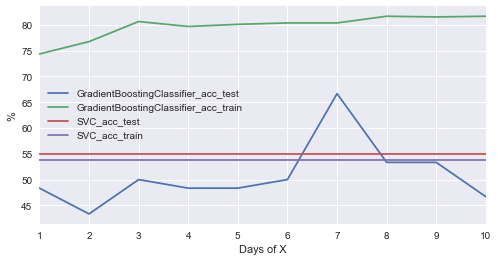

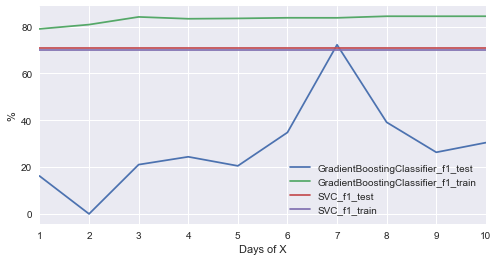

In [206]:
best_feature          = score_day(X = X, y = y, size = Page_size/2,
     feature_days_max = 10
   , feature          = feature_base
                                 )

----
## Improving Results

### Choosing the Best Model

**GradientBoostingClassifier** is the best model of the three models because of the **best F score, predicting time** and **good training time**. The algorithm is also suitable to handle the **mixed type of data** (heterogeneous features, Ref.: [`sklearn/modules/gradient-tree-boosting`](http://scikit-learn.org/stable/modules/ensemble.html#gradient-tree-boosting)).

The **Ensemble (Gradient Tree Boosting)** is based on the
**Tree**s which are composed of many feature-evaluation flows to prediction the income of every individual. For each individual, each tree starts from a specified feature-evaluation, e.g., age, to select the next branched feature-evaluations. After a sequence of sophisticated feature classification, the individual is classified to a predicted income class by a tree. 
The **Gradient** means: the feature selections, orders, and evaluation criteria of trees are tuned based on the prediction trend of the large data calculated by the calculus. 
The **Boosting** means: when tuning the trees, the false-predicted data will be weighted high to improve the weakness. 
The **Ensemble** means: The trees can vote as a team to perform better prediction than an individual. Each tree has different weaknesses and strengths because they grow and are tuned by arbitrary different data to try any better possibility.

### Implementation: Model Tuning

The best classifier is GradientBoostingClassifier with  74.29% f1-score and 13-day features per prediction


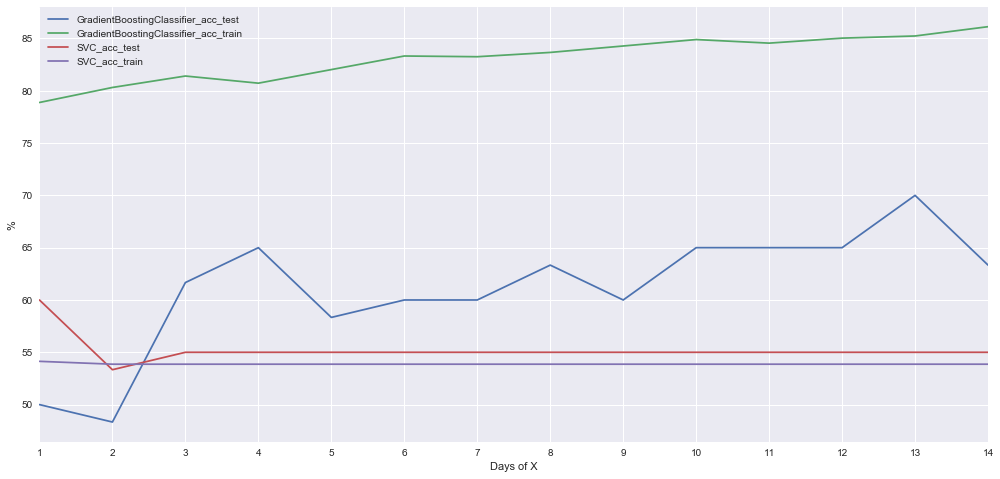

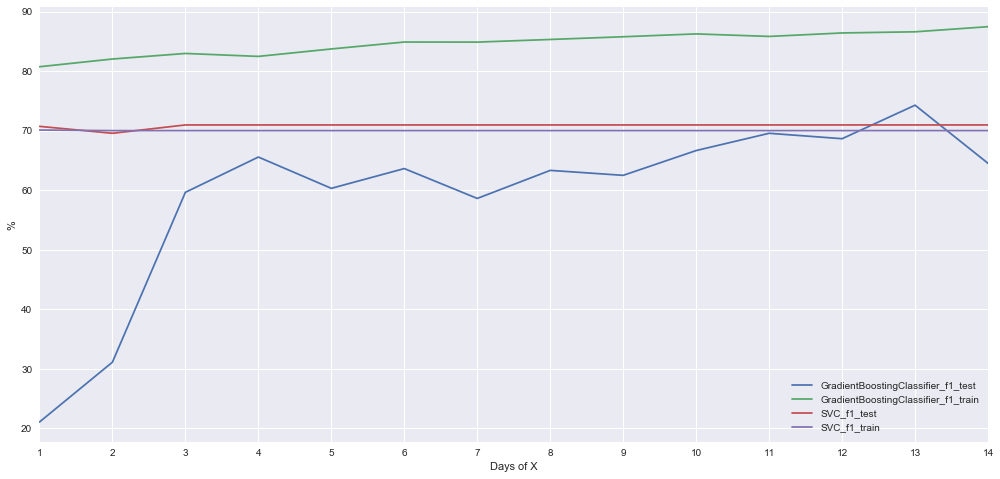

In [216]:
best_feature          = score_day(X = X, y = y,
     feature_days_max =
                        14
   , feature          = feature_base
#                       + feature_vec
                      + feature_next
#                       + feature_stat
                                 )

----
## Feature Importance

### Implementation - Extracting Feature Importance

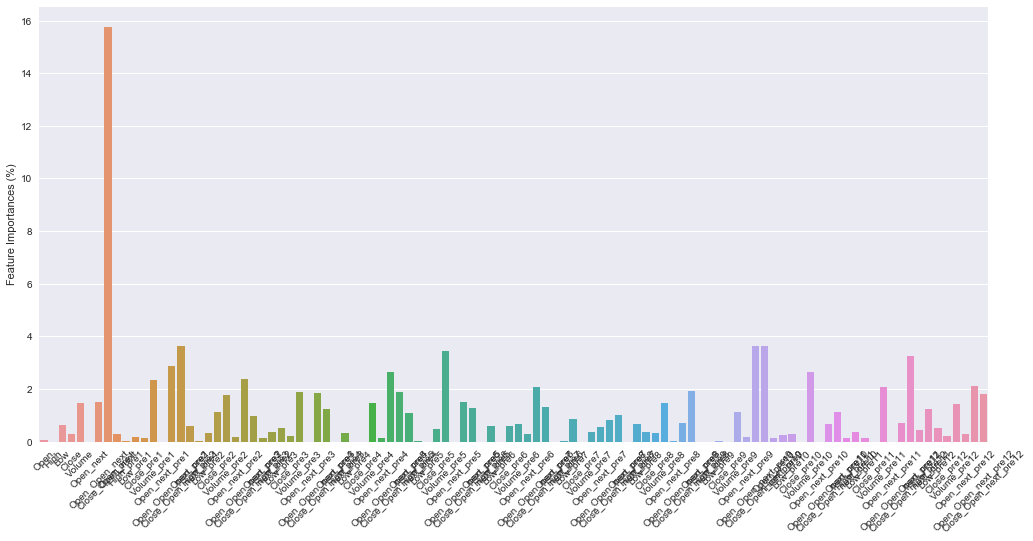

In [217]:
f = sns.barplot(best_feature['feature'],
                best_feature['clf'    ].feature_importances_*100,
                ax  = plt.subplots(figsize = (Page_size, Page_size/2))[1]);
f.set_xticklabels(f.get_xticklabels(), rotation = 45)
f.set_ylabel     ('Feature Importances (%)');

In [218]:
def        feature_importances(     feature, learner):
    df = pd.DataFrame         ({
       'Features'   :               feature,
       'Importances':                        learner.feature_importances_*100}).sort_values(by =
       'Importances', ascending = 0). reset_index(drop = 1).rename(index = lambda c: c + 1)
    df['Importances'] = df['Importances'].map(percent.format)
    return df

from sklearn.ensemble import GradientBoostingRegressor
def        feature_importances_GBR(X_train,               y_train, random_state = random_state, X_test = None, y_test = None):
    return feature_importances(    X_train.columns,
                               GradientBoostingRegressor         ( random_state = random_state).
                               fit(X_train,               y_train))

feature_importances_default = feature_importances(best_feature['feature'],
                                                  best_feature['clf'    ])

display(pd.concat([feature_importances_default,
                   feature_importances_GBR(**best_feature['Xy'])], axis = 1, keys = ['Classifier', 'Regressor']).head())

Classifier                         Regressor            
               Features Importances              Features Importances
1       Close_Open_next      15.74%       Close_Open_next      14.37%
2  Close_Open_next_pre9       3.64%  Close_Open_next_pre1       4.12%
3   Open_Open_next_pre9       3.62%           Volume_pre5       4.03%
4  Close_Open_next_pre1       3.62%  Close_Open_next_pre4       3.37%
5           Volume_pre5       3.42%          Volume_pre10       3.24%

### Feature Relevance Observation

In [142]:
from sklearn.model_selection import GridSearchCV
from sklearn.metrics         import make_scorer
from sklearn.model_selection import TimeSeriesSplit
from sklearn.pipeline        import Pipeline

# scaler     = MinMaxScaler()
# clf        = SVC         ()
clf        = GradientBoostingClassifier(random_state = random_state, warm_start = True)

def clfTimeGrid(         clf , parameters,
                                  X_train, y_train,                         X_test, y_test,
                                                                                    n_splits = 3               , beta = beta):
    print 'Parameter Grid:'
    display(pd.DataFrame.from_dict(parameters, orient = 'index', dtype = object).T.fillna('').rename(index = lambda c: c + 1))
#     pipe               = Pipeline(steps=[('scaler', scaler), ('clf', clf)])
#     grid               = GridSearchCV(clf, parameters, scoring = 'roc_auc'      (   fbeta_score              , beta = beta),
    grid               = GridSearchCV(clf, parameters, scoring = make_scorer    (   fbeta_score                , beta = beta),
                                                       cv      = TimeSeriesSplit(   n_splits = n_splits) .split(X_train))
    predict_train      = clf .fit(X_train, y_train)                .predict(X_train)
    predict_test       = clf                                       .predict(X_test )
    estimator          = grid.fit(X_train, y_train).best_estimator_
    predict_best_train =                                 estimator .predict(X_train)
    predict_best_test  =                                 estimator .predict(X_test )

    display(concat([pd.DataFrame(OrderedDict([
      ('Train Accuracy'                   ,  [               accuracy_score(        y_train, predict_train                  )  ,
                                                             accuracy_score(        y_train, predict_best_train             )]),
      ( 'Test Accuracy'                   ,  [               accuracy_score(        y_test , predict_test                   )  ,
                                                             accuracy_score(        y_test , predict_best_test              )]),
      ('Train {}'.format('F-' + str(beta)),  [                  fbeta_score(        y_train, predict_train     , beta = beta)  ,
                                                                fbeta_score(        y_train, predict_best_train, beta = beta)]),
      ( 'Test {}'.format('F-' + str(beta)),  [                  fbeta_score(        y_test , predict_test      , beta = beta)  ,
                                                                fbeta_score(        y_test , predict_best_test , beta = beta)]),
                                 ])).applymap(lambda s: '{:.2f}%'.format(100*s)),
         pd.concat([pd.DataFrame(   c. get_params(), index = [0])[parameters.keys()],
                    pd.DataFrame(grid.best_params_ , index = [1])[parameters.keys()]])])
                                             .rename(index = {0:   'Default Model',
                                                              1: 'Optimized Model'}))
    return grid, feature_importances(X_train.columns, grid.best_estimator_)

The best classifier is GradientBoostingClassifier with  74.29% f1-score and 13-day features per prediction


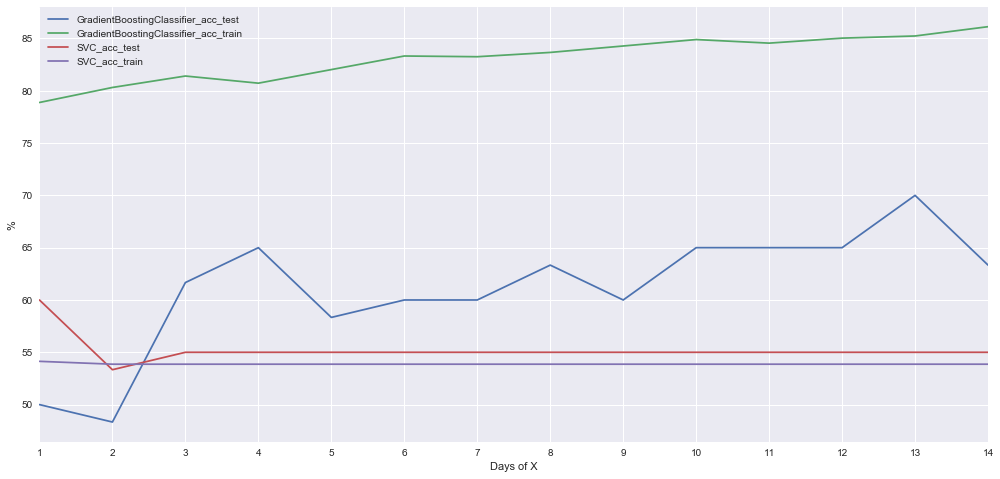

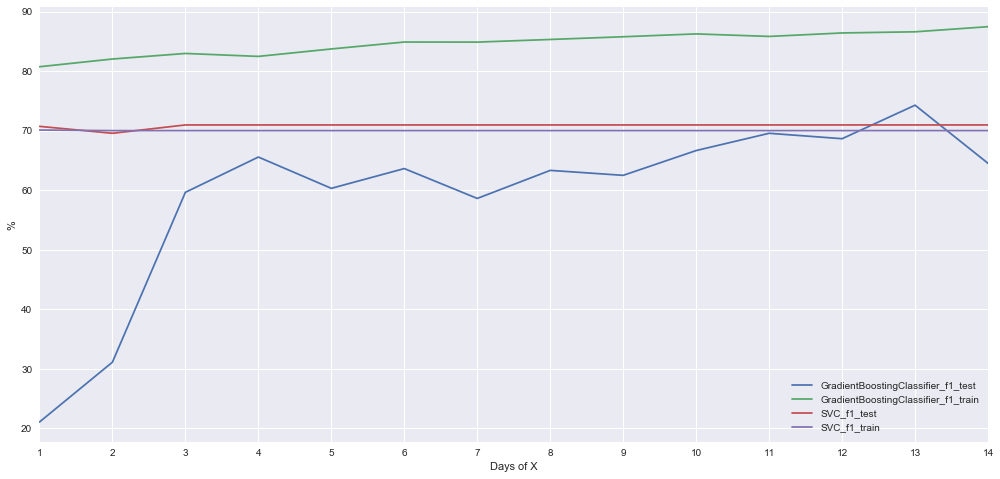

In [228]:
best_feature          = score_day(X = X, y = y,
     feature_days_max = 14
   , feature          = [
                         'Open'           ,
                         'High'           ,
                         'Low'            ,
                         'Close'          ,
                         'Volume'         ,
#                          'Open_Close'     ,
                         'Open_next'      ,
                         'Open_Open_next' ,
                         'Close_Open_next',
#                          'RSI6'           ,
#                          'C2M'            ,
#                          'MACD'           ,
#                          'Boll_u'         ,
#                          'Boll'           ,
#                          'Boll_l'         ,
                         ])

In [223]:
feature_importances_default = feature_importances(best_feature['feature'],
                                                  best_feature['clf'    ])
display(feature_importances_default.head())

,Features,Importances
1,Close_Open_next,15.74%
2,Close_Open_next_pre9,3.64%
3,Open_Open_next_pre9,3.62%
4,Close_Open_next_pre1,3.62%
5,Volume_pre5,3.42%


In [224]:
clf        = GradientBoostingClassifier(random_state = random_state, warm_start = True)

parameters = OrderedDict([
    ('learning_rate'    ,
    [
#         0.2             ,
        0.1             ,
#         0.05            ,
    ]                  ),
    ('n_estimators'     ,
#      range             (
#          20             ,
#          81             ,
#          10
#                        )+
    [
#       100               ,
       70               ,
#        40               ,
    ]                  ),
    ('max_depth'        ,
#      range             (
#         5               ,
#         8               ,
#         9               ,
#        10               ,
#        11               ,
#        17               ,
#                        )+
    [
#        8                ,
       6                ,
#        5                ,
#        3                ,
    ]                  ),
    ('min_samples_split',
     range             (
#         4               ,
#         6               , # 0.5*len(y)
#         7               ,
#         8               ,
#        10               ,
       11               ,
#        13               , #     len(y)
       15               ,
                       )+
    [                   
#        2                ,
#        5                ,
#        6                ,
#       10                ,
    ]                  ),
    ('min_samples_leaf' ,
#      range             (
# #         1               ,
# #         4               ,
#         6               ,
#        11               ,
# #        12               ,
# #        14 
#                        )+
    [
#         1               ,
#         4               ,
#         5               ,
       10               ,
    ]                  ),
    ('max_features'     ,
    [
#         None            ,
#         0.4             ,
#         0.3             ,
        'sqrt'          ,
    ]                  ),
    ('subsample'        ,
    [
        0.8             ,
#         0.9             ,
#         1               ,
    ]                  ),
    ]                  )
# parameters = OrderedDict([
#     ('learning_rate'    , [        0.1   ,    ]        ),
#     ('n_estimators'     , [      100     ,    ]        ),
#     ('max_depth'        , [        3     ,    ]        ),
#     ('min_samples_split', [        2     ,    ]        ),
#     ('min_samples_leaf' , [        1     ,    ]        ),
#     ])
# parameters = [{'kernel': ['rbf'   ], 'C': [1, 10, 100, 1000], 'gamma': [1e-3, 1e-4]},
#               {'kernel': ['linear'], 'C': [1, 10, 100, 1000]                       }]

grid, importances = clfTimeGrid(clf, parameters, **best_feature['Xy'])
display(pd.concat([feature_importances_default, importances], axis = 1, keys = ['Default', 'Optimized']).head())

Parameter Grid:


,learning_rate,n_estimators,max_depth,min_samples_split,min_samples_leaf,max_features,subsample
1,0.1,70,6,11,10,sqrt,0.8
2,,,,12,,,
3,,,,13,,,
4,,,,14,,,


,Train Accuracy,Test Accuracy,Train F-1,Test F-1,learning_rate,n_estimators,max_depth,min_samples_split,min_samples_leaf,max_features,subsample
Default Model,85.24%,70.00%,86.62%,74.29%,0.1,100,3,2,1,None,1.0
Optimized Model,96.38%,60.00%,96.66%,63.64%,0.1,70,6,11,10,sqrt,0.8


Default                        Optimized            
               Features Importances             Features Importances
1       Close_Open_next      15.74%      Close_Open_next      14.58%
2  Close_Open_next_pre9       3.64%  Open_Open_next_pre6       2.11%
3   Open_Open_next_pre9       3.62%          Volume_pre1       2.09%
4  Close_Open_next_pre1       3.62%  Open_Open_next_pre9       2.00%
5           Volume_pre5       3.42%  Open_Open_next_pre5       1.96%

### Final Model Evaluation

Close_next Regression r2-Score:  73.48%
Close_next Up/Down Classification Accuracy Score by Regression:  55.00%
Close_next Up/Down Classification       F1-Score by Regression:  70.97%


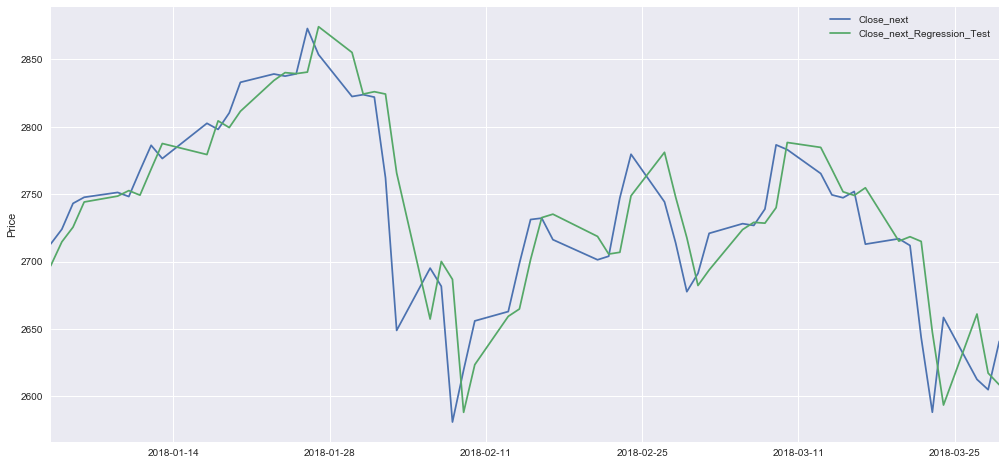

Open_next Regression r2-Score:  97.12%
Open_next Up/Down Classification Accuracy Score by Regression:  81.67%
Open_next Up/Down Classification       F1-Score by Regression:  83.08%


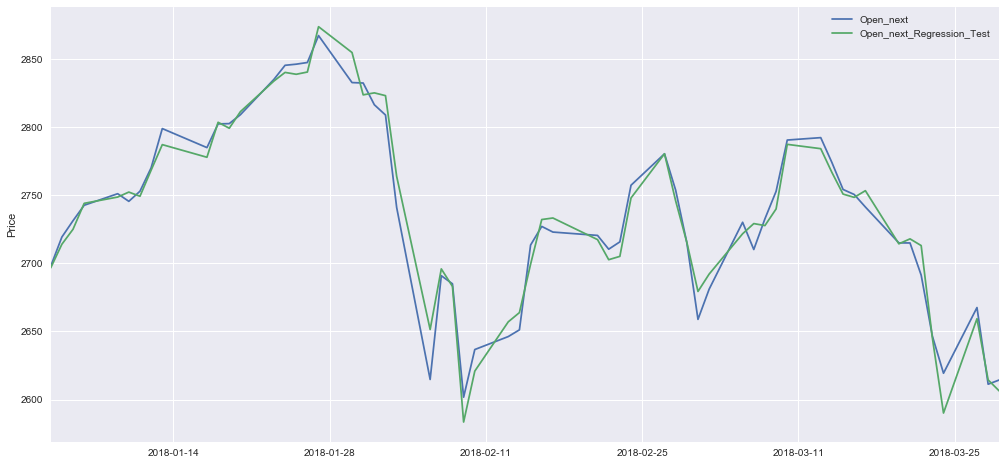

In [43]:
labels          =  ['Close_next', 'Open_next']

from sklearn.metrics import           r2_score

data_train,       data_test = Split1(data_log[day_range_Max - 1:], date_split)
for label in labels:
    y_train_raw = data_train[[label]]
    y_test_raw  = data_test [[label]]
    scaler_y    =        MinMaxScaler().fit            (                                                  y_train_raw )
    regressor   =    LinearRegression().fit            (X_train[feature_base], scaler_y.        transform(y_train_raw))
    predict     =          regressor   .       predict (X_test [feature_base])
    predict_raw =                                                              scaler_y.inverse_transform(
                                               predict                                                   )
    regression  = y_test_raw.copy()
    regression[label +   '_Regression_Test'] = predict_raw
    classification = data_test[label.split('_')[0]] <= regression
    x           = label.split('_')[0]
    acc, f1     = clf_scores(data_test[                  x        ] <= regression.iloc[:, -1],
                             data_test['{}_{}_up'.format(x, label)]                          , beta)
    print              '{} Regression r2-Score: {:6.2f}%'                         .format (label, 100*
                                      r2_score(predict                       , scaler_y.        transform(y_test_raw )))
    print  '{} Up/Down Classification Accuracy Score by Regression: {:6.2f}%'.format (label, 100* acc)
    print  '{} Up/Down Classification       F1-Score by Regression: {:6.2f}%'.format (label, 100*  f1)
    ax = regression.plot( figsize = (Page_size, Page_size/2));
    ax .    set_ylabel  ('Price')
    plt.show()